In [8]:
# ======================================
# 1. Install/Import Required Libraries
# ======================================

import pandas as pd
from google_play_scraper import Sort, reviews
import subprocess
from tqdm import tqdm

In [18]:
# ======================================
# 2. Define Parameters
# ======================================

# Package name of the BMW app on Google Play:
app_id = "de.bmw.connected.mobile20.row"

# Ollama model
ollama_model_name = "llama3.2:3b-instruct-fp16"

# Prompt template for sentiment classification.
ollama_prompt_template = """You are a precise sentiment classifier. Your task is to classify the following BMW app review as exactly one of: positive, negative, or neutral.

BMW App Review: "{review_text}"

Respond with only a single word - positive, negative, or neutral. Do not include any explanations, punctuation, or additional text, keep it lowercase.
"""

In [10]:
# ======================================
# 3. Fetch Reviews from Google Play Store
# ======================================

# Define languages to fetch (just language codes and labels)
languages = [
    ('en', 'English'),
    ('de', 'German'),
    ('fr', 'French'),
    ('it', 'Italian'),
    ('es', 'Spanish'),
    ('nl', 'Dutch'),
    ('sv', 'Swedish'),
    ('da', 'Danish'),
    ('no', 'Norwegian'),
    ('fi', 'Finnish'),
    ('pl', 'Polish'),
    ('cs', 'Czech'),
    ('pt', 'Portuguese'),
    ('zh', 'Chinese'),
    ('ja', 'Japanese'),
    ('ko', 'Korean'),
    ('ar', 'Arabic'),
    ('tr', 'Turkish'),
    ('ru', 'Russian'),
    ('he', 'Hebrew'),
    ('th', 'Thai'),
    ('vi', 'Vietnamese'),
    ('hi', 'Hindi'),
    ('el', 'Greek'),
    ('hu', 'Hungarian'),
    ('ro', 'Romanian'),
    ('sk', 'Slovak'),
    ('bg', 'Bulgarian'),
    ('hr', 'Croatian'),
    ('sr', 'Serbian'),
    ('uk', 'Ukrainian'),
    ('id', 'Indonesian'),
    ('ms', 'Malay'),
    ('fa', 'Persian'),
    ('ur', 'Urdu'),
    ('bn', 'Bengali'),
    ('ta', 'Tamil'),
    ('te', 'Telugu'),
    ('ml', 'Malayalam'),
    ('et', 'Estonian'),
    ('lv', 'Latvian'),
    ('lt', 'Lithuanian'),
    ('sl', 'Slovenian')
]

# Initialize empty list to store all reviews
all_reviews = []

# Fetch reviews for each language
for lang_code, lang_label in languages:
    continuation_token = None
    prev_length = len(all_reviews)
    
    while True:
        result, continuation_token = reviews(
            app_id,
            lang=lang_code,
            sort=Sort.NEWEST,
            count=100,
            continuation_token=continuation_token
        )
        
        # Add language label to each review
        for review in result:
            review['language'] = lang_label
        
        all_reviews.extend(result)
        
        # Break if no more reviews or if number of reviews isn't increasing
        current_length = len(all_reviews)
        if not continuation_token or current_length - prev_length < 100:
            break
            
        prev_length = current_length

# Convert all reviews into a pandas DataFrame
df = pd.DataFrame(all_reviews)

print("\nReview Statistics:")
print("=" * 50)
print(f"Total number of reviews collected: {len(df)}")
print("\nBreakdown by language:")
print("-" * 50)
language_counts = df['language'].value_counts()
print(language_counts)
print("-" * 50)
print(f"Number of languages with reviews: {len(language_counts)}")
# Inspect the first few rows
df.head()


Review Statistics:
Total number of reviews collected: 17970

Breakdown by language:
--------------------------------------------------
language
German        4834
English       4531
French        1661
Italian       1292
Dutch          945
Spanish        941
Polish         627
Portuguese     565
Russian        466
Romanian       275
Swedish        256
Norwegian      200
Japanese       197
Finnish        172
Czech          156
Greek          114
Hungarian      112
Danish         101
Thai            96
Croatian        64
Turkish         59
Slovak          56
Slovenian       51
Chinese         47
Bulgarian       43
Arabic          31
Serbian         19
Ukrainian       14
Lithuanian      12
Estonian         9
Latvian          7
Indonesian       6
Korean           4
Hebrew           4
Malay            2
Persian          1
Name: count, dtype: int64
--------------------------------------------------
Number of languages with reviews: 36


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,language
0,f09dee70-2ff8-4fa5-82d9-47613a5cdb55,Charles Kakuli,https://play-lh.googleusercontent.com/a-/ALV-U...,Exceptionally awesome. So convenient.,5,0,4.11.3,2025-03-18 07:10:53,None,NaT,4.11.3,English
1,b3a46381-e625-42ff-8698-6714027c78ad,vanessa wong,https://play-lh.googleusercontent.com/a-/ALV-U...,App has not been able to update the vehicle st...,2,0,5.3.1,2025-03-17 22:54:07,Hi Vanessa! Thank you for your feedback. We re...,2025-03-19 15:09:54,5.3.1,English
2,9f341388-59f6-499a-9c38-853ee02bd237,Roger Tay,https://play-lh.googleusercontent.com/a-/ALV-U...,The digital key does not work with my new phon...,1,0,5.3.1,2025-03-17 04:43:20,None,NaT,5.3.1,English
3,4cf99b13-eef8-468c-8aa2-b47c9500705f,Kevin,https://play-lh.googleusercontent.com/a-/ALV-U...,Wish you could do dynamic refresh of car statu...,2,0,5.3.1,2025-03-16 18:34:49,None,NaT,5.3.1,English
4,fd0c04a3-3157-4e7a-81b6-af67b7dce651,Petar Nikolov,https://play-lh.googleusercontent.com/a-/ALV-U...,Version 5.3.1 is partly working. Monitoring of...,1,0,None,2025-03-15 10:05:45,Hi Petar! Thank you for your feedback. We regr...,2025-03-19 15:06:12,None,English


In [11]:
# ======================================
# 4. Sample Reviews
# ======================================
# After creating the initial DataFrame, add this line to sample 500 random reviews
df2 = df.sample(n=500, random_state=42)  # random_state ensures reproducibility
print(f"Sampled {len(df2)} random reviews for analysis")

Sampled 500 random reviews for analysis


In [13]:
# ======================================
# 5. Translate Non-English Reviews
# ======================================

def translate_text(text, source_lang, ollama_model_name):
    """
    Translate text to English using Ollama.
    
    :param text: Text to translate
    :param source_lang: Source language label (e.g., 'German', 'French')
    :param ollama_model_name: Name of the Ollama model to use
    :return: Translated text
    """
    prompt = f"""You are a professional translator specializing in mobile app reviews. Translate the following {source_lang} BMW app review into fluent, natural English.

Original {source_lang} review: "{text}"

Rules:
1. Preserve the original sentiment and tone completely
2. Maintain technical terms related to BMW vehicles or app features
3. Translate idioms and expressions to their English equivalents
4. Return ONLY the translated text with no explanations, notes, or additional content

English translation:"""
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

# Create a copy of the original content
df2['content_english'] = df2['content']

# Translate non-English reviews
for idx in tqdm(df2[df2['language'] != 'English'].index, desc="Translating reviews"):
    original_text = df2.loc[idx, 'content']
    source_lang = df2.loc[idx, 'language']
    
    translated_text = translate_text(original_text, source_lang, ollama_model_name)
    df2.loc[idx, 'content_english'] = translated_text

# Display a few examples of translated reviews
print("\nExample translations:")
print(df2[['language', 'content', 'content_english']].head(3))

Translating reviews: 100%|██████████| 381/381 [10:51<00:00,  1.71s/it]


Example translations:
       language                         content  \
6351     German           Kann sie nicht öffnen   
17650  Romanian  Buna aplicatia. Ceva deosebit!   
1713    English             Everything is fine.   

                                         content_english  
6351                    "I have been unable to open it."  
17650  I'm ready to translate. What's the Romanian re...  
1713                                 Everything is fine.  


In [14]:
# ======================================
# 6. Display Translation Results
# ======================================

# Set display options to show full content
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.width', None)         # Don't wrap to new lines

# Print rows 6000 to 6010 with specified columns
print(df2[['language', 'content', 'content_english']].head(10))

# Reset display options to default (optional)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

       language  \
6351     German   
17650  Romanian   
1713    English   
1611    English   
9498     French   
9394     French   
322     English   
4894     German   
5224     German   
2133    English   

                                                                                                                                                                                                                         content  \
6351                                                                                                                                                                                                       Kann sie nicht öffnen   
17650                                                                                                                                                                                             Buna aplicatia. Ceva deosebit!   
1713                                                                                                      

In [15]:
# ======================================
# 7. Define Sentiment Analysis Function
# ======================================

def get_sentiment_from_ollama(text, model_name=ollama_model_name):
    
    # Use the English translation for non-English reviews
    text_to_analyze = text['content_english'] if isinstance(text, pd.Series) else text
    
    # Prepare the prompt by injecting our text into the template
    prompt = ollama_prompt_template.format(review_text=text_to_analyze)
    
    # Use subprocess.run to call Ollama
    process = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    # Ollama's output is in process.stdout
    output = process.stdout.strip()

    return output

In [19]:
# ======================================
# 8. Run Sentiment Analysis
# ======================================

# Print total number of reviews before starting
total_reviews = len(df2)
print(f"Starting sentiment analysis on {total_reviews} reviews...")

sentiments = []
for idx, row in tqdm(df2.iterrows(), 
                     desc="Analyzing Sentiment", 
                     total=total_reviews,
                     position=0):
    sentiment_label = get_sentiment_from_ollama(row)
    sentiments.append(sentiment_label)
    
    # Print progress every 100 reviews
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{total_reviews} reviews")

# Add the sentiments to the DataFrame
df2['sentiment'] = sentiments

# Print final count
print(f"\nCompleted sentiment analysis on {len(sentiments)} reviews")

Starting sentiment analysis on 500 reviews...


Analyzing Sentiment:  14%|█▎        | 68/500 [00:16<01:40,  4.30it/s]

Processed 3600/500 reviews


Analyzing Sentiment:  21%|██        | 103/500 [00:24<01:33,  4.27it/s]

Processed 11300/500 reviews


Analyzing Sentiment:  24%|██▍       | 121/500 [00:28<01:28,  4.30it/s]

Processed 7700/500 reviews


Analyzing Sentiment:  38%|███▊      | 190/500 [00:43<01:14,  4.13it/s]

Processed 16500/500 reviews


Analyzing Sentiment:  41%|████      | 203/500 [00:46<01:07,  4.41it/s]

Processed 10400/500 reviews


Analyzing Sentiment:  52%|█████▏    | 262/500 [00:59<00:50,  4.69it/s]

Processed 1600/500 reviews


Analyzing Sentiment:  58%|█████▊    | 292/500 [01:06<00:45,  4.55it/s]

Processed 8900/500 reviews


Analyzing Sentiment:  81%|████████  | 406/500 [01:31<00:21,  4.40it/s]

Processed 2500/500 reviews


Analyzing Sentiment: 100%|██████████| 500/500 [01:51<00:00,  4.48it/s]


Completed sentiment analysis on 500 reviews


Sentiment Distribution:
sentiment
negative    202
neutral     183
positive    115
Name: count, dtype: int64


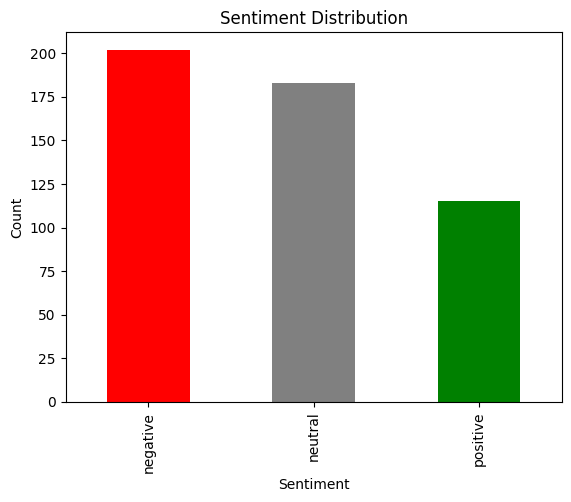

In [20]:
# ======================================
# 9. Analyze Sentiment Distribution
# ======================================

# Count how many times each sentiment occurs
sentiment_counts = df2['sentiment'].value_counts()

print("Sentiment Distribution:")
print(sentiment_counts)

# Define a color map for each sentiment
sentiment_color_dict = {
    "positive": "green",
    "negative": "red",
    "neutral": "gray"
}

# Create a list of colors
color_list = [sentiment_color_dict.get(label, "blue") for label in sentiment_counts.index]

# Create the bar plot
ax = sentiment_counts.plot(
    kind='bar', 
    title='Sentiment Distribution', 
    xlabel='Sentiment', 
    ylabel='Count',
    color=color_list
)

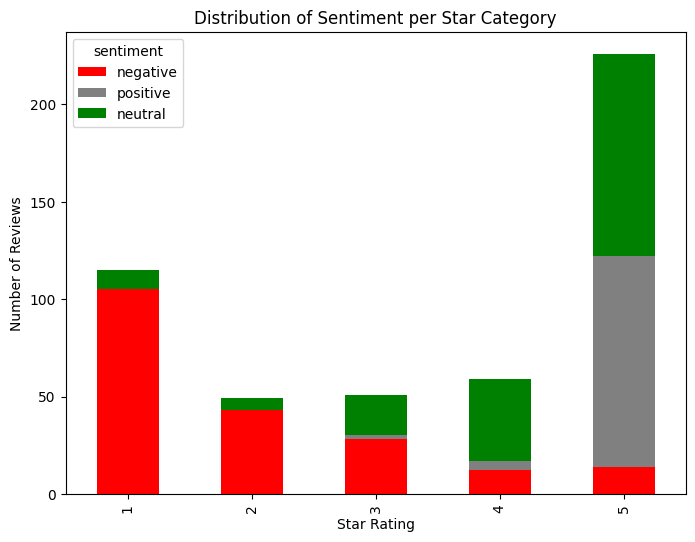

In [22]:
# ======================================
# 10. Plot Sentiment per Star Rating
# ======================================

import matplotlib.pyplot as plt

# Group by 'score' (star rating) and 'sentiment', then count how many reviews
grouped = df2.groupby(['score', 'sentiment']).size().unstack(fill_value=0)

# Reorder the columns
column_order = ['negative', 'positive', 'neutral']
grouped = grouped.reindex(columns=column_order, fill_value=0)

# Plot as a stacked bar chart
ax = grouped.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8, 6),
    title='Distribution of Sentiment per Star Category',
    color=color_list
)

ax.set_xlabel('Star Rating')
ax.set_ylabel('Number of Reviews')

plt.show()

In [23]:
# ======================================
# 12. Define Topic Categories
# ======================================

# Expanded comprehensive topic list for MyBMW app
REVIEW_TOPICS = """
1. UI/UX:
   - User interface, app design, ease of use, navigation, overall visual appeal.
2. Performance:
   - App speed, crashes, bugs, stability, battery drain.
3. Connectivity:
   - Connection issues, Bluetooth, server problems, integration with external devices.
4. Authentication:
   - Login issues, account problems, multi-factor authentication, session timeouts.
5. Vehicle Status:
   - Battery, fuel, location, diagnostics.
6. Remote Controls:
   - Lock/unlock, climate control, remote start.
7. Trip Planning:
   - Route optimization, scheduling, and related features.
8. Charging Management:
   - Charging status, locating charging stations, scheduling.
9. Map/Navigation:
   - Maps functionality, route planning, GPS accuracy, alternative route suggestions.
10. Mobile Features:
    - Widgets, notifications, mobile-specific interactions, quick-access features.
11. Data & Privacy:
    - Data handling, privacy concerns, data sharing, security practices.
12. Updates:
    - App updates, version issues, patch notes, update-related bugs.
13. Feature Requests:
    - Desired new functionality, user suggestions for enhancements.
14. Customer Support:
    - Support experience, response time, issue resolution, helpdesk effectiveness.
15. Connected Store:
    - In-app store experience, product browsing, payment process, promotional offers, purchase issues, ease of transaction.
16. BMW Digital Premium:
    - Subscription service experience, access to premium features, content quality, subscription pricing, management of subscription settings.
17. Digital Key/Mobile Key:
    - Phone as key functionality, digital key sharing, key card backup options, access management.
18. Vehicle Configuration & Personalization:
    - Driver profiles, vehicle settings customization, personalized driving modes, saved preferences.
19. Multimedia Integration:
    - Music/entertainment control, Spotify/Apple Music integration, media streaming, audio settings.
20. Smartphone Integration:
    - Apple CarPlay, Android Auto connectivity, screen mirroring, phone-to-vehicle interface.
21. Service & Maintenance:
    - Service scheduling, maintenance alerts, service history tracking, dealer appointment booking.
22. Parking Solutions:
    - Parking location services, parking payment integration, garage/lot availability, last parked location.
23. Voice Assistant:
    - BMW Intelligent Personal Assistant functionality, voice command accuracy, voice control features.
24. My Garage/Vehicle Management:
    - Multi-vehicle support, vehicle profiles, adding/removing vehicles from account.
25. Localization & Language:
    - Translation issues, region-specific feature availability, language support.
26. BMW Connected Ecosystem:
    - Integration with other BMW services, Connected Drive features, BMW ID account.
27. EV-Specific Features:
    - Range prediction, battery optimization, preconditioning, charging schedules for electric BMW vehicles.
"""

def label_review_topics(text, model_name=ollama_model_name):
    """
    Label a review with relevant topics using Ollama.
    
    :param text: Review text to analyze
    :param model_name: Ollama model name
    :return: List of identified topics
    """
    prompt = f"""You are a specialized BMW app review classifier. Your task is to analyze the BMW app review below and identify ALL relevant topics it discusses.

INSTRUCTION:
Use ONLY the topic categories from this list:
{REVIEW_TOPICS}

BMW App Review: "{text}"

OUTPUT GUIDELINES:
1. Return ONLY a comma-separated list of topics (e.g., "UI/UX, Performance, Remote Controls")
2. Use the exact topic names as they appear in the list (e.g., "UI/UX" not "User Interface")
3. Include 1-5 topics maximum, focusing on the most relevant ones
4. If a topic is mentioned but with low confidence, still include it
5. For empty, unclear, or non-app related reviews, output "Other"
6. Do not include explanations, notes, or any text besides the topic list
7. Do not number the topics in your response
8. If the review mentions a specific feature, map it to the closest category

Examples:
- "The app keeps crashing when I try to check my car's fuel level" → "Performance, Vehicle Status"
- "Love the new design, much easier to use now" → "UI/UX"
- "Can't log in and customer service is unhelpful" → "Authentication, Customer Support"
- "This app is garbage" → "Other"

Output your topic list here:"""
    
    process = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

In [24]:
# ======================================
# 13. Apply Topic Labeling
# ======================================

print("Starting topic analysis...")
topics = []
for idx, row in tqdm(df2.iterrows(), 
                     desc="Analyzing Topics", 
                     total=len(df2),
                     position=0):
    # Use English content for consistency
    review_topics = label_review_topics(row['content_english'])
    topics.append(review_topics)
    
    # Print progress every 100 reviews
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(df2)} reviews")

# Add topics to DataFrame
df2['topics'] = topics

Starting topic analysis...


Analyzing Topics:  14%|█▎        | 68/500 [00:49<05:09,  1.40it/s]

Processed 3600/500 reviews


Analyzing Topics:  20%|██        | 102/500 [01:14<04:50,  1.37it/s]

Processed 11300/500 reviews


Analyzing Topics:  24%|██▍       | 121/500 [01:28<04:46,  1.32it/s]

Processed 7700/500 reviews


Analyzing Topics:  38%|███▊      | 190/500 [02:18<04:00,  1.29it/s]

Processed 16500/500 reviews


Analyzing Topics:  40%|████      | 202/500 [02:26<03:34,  1.39it/s]

Processed 10400/500 reviews


Analyzing Topics:  52%|█████▏    | 262/500 [03:09<02:52,  1.38it/s]

Processed 1600/500 reviews


Analyzing Topics:  58%|█████▊    | 292/500 [03:30<02:26,  1.42it/s]

Processed 8900/500 reviews


Analyzing Topics:  81%|████████  | 405/500 [04:53<01:11,  1.33it/s]

Processed 2500/500 reviews


Analyzing Topics: 100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


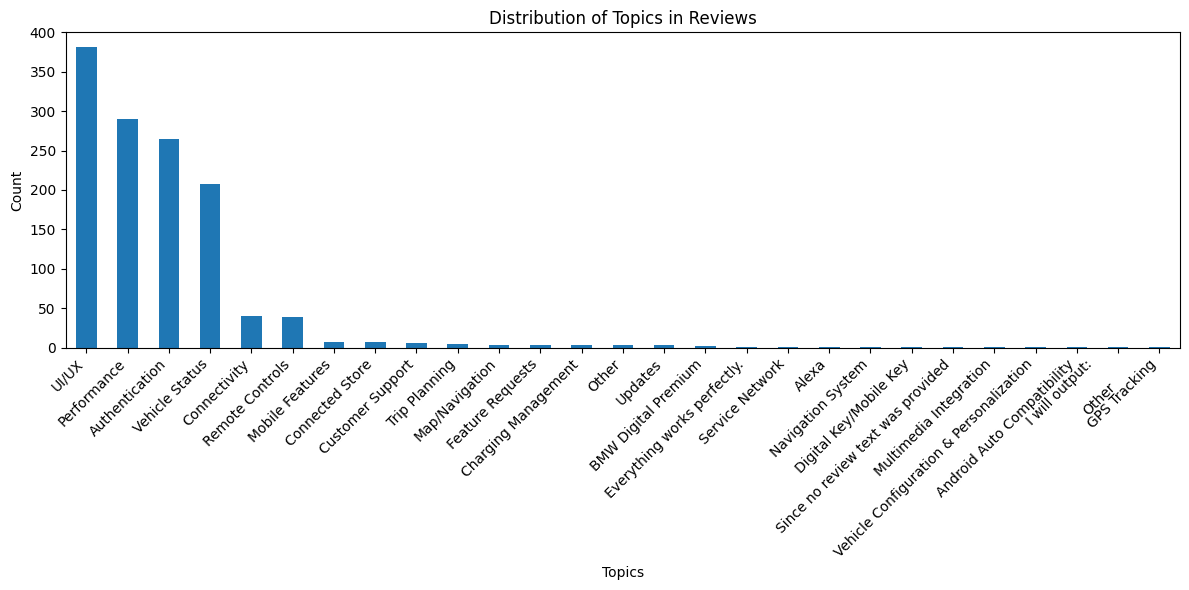

In [25]:
# ======================================
# 14. Analyze Topic Distribution
# ======================================

# Split the comma-separated topics and create a flat list
all_topics = []
for topic_list in df2['topics']:
    topics = [t.strip() for t in topic_list.split(',')]
    all_topics.extend(topics)

# Count topic frequencies
topic_counts = pd.Series(all_topics).value_counts()

# Plot topic distribution
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Topics in Reviews')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

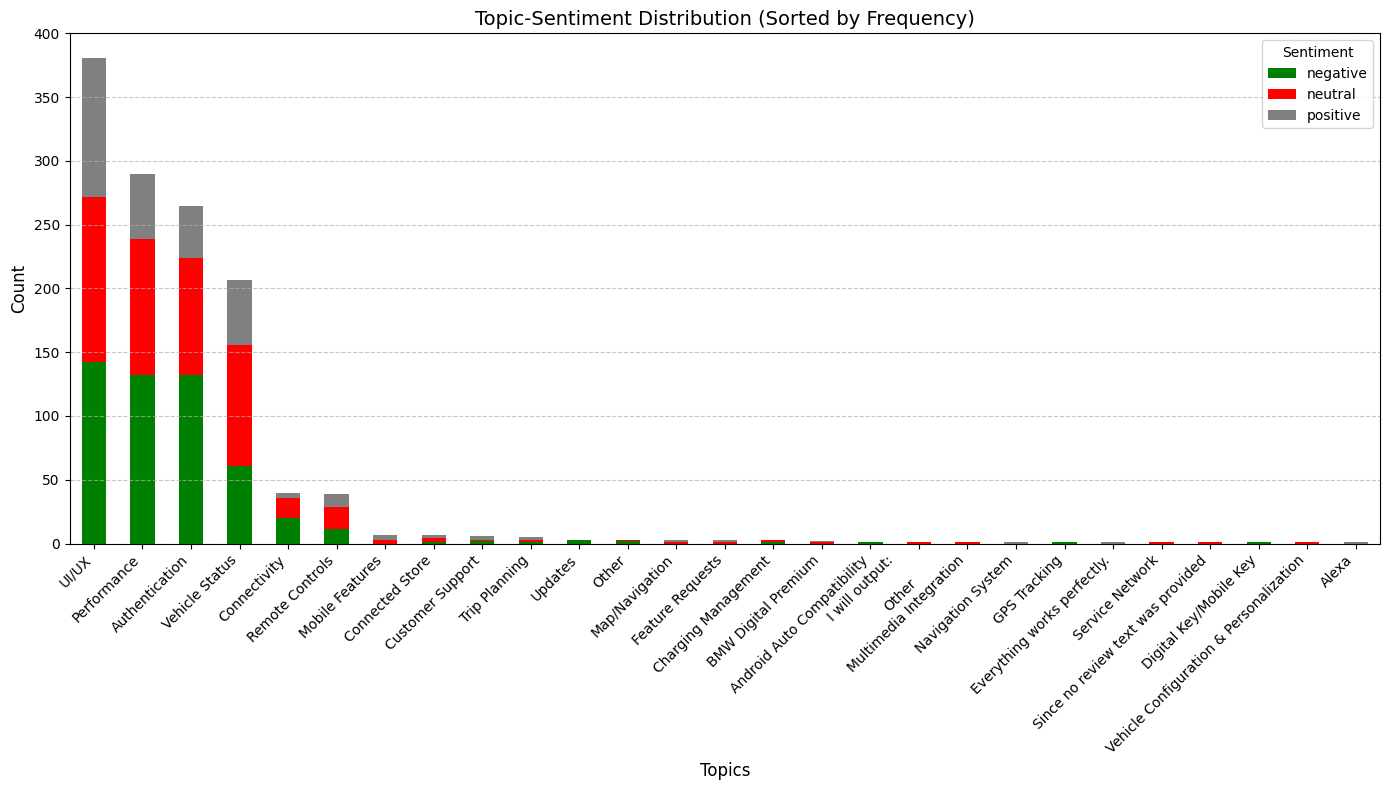

Topic Frequencies (Most to Least Mentioned):
UI/UX: 381 mentions
Performance: 290 mentions
Authentication: 265 mentions
Vehicle Status: 207 mentions
Connectivity: 40 mentions
Remote Controls: 39 mentions
Mobile Features: 7 mentions
Connected Store: 7 mentions
Customer Support: 6 mentions
Trip Planning: 5 mentions
Map/Navigation: 3 mentions
Feature Requests: 3 mentions
Charging Management: 3 mentions
Other: 3 mentions
Updates: 3 mentions
BMW Digital Premium: 2 mentions
Everything works perfectly.: 1 mentions
Service Network: 1 mentions
Alexa: 1 mentions
Navigation System: 1 mentions
Digital Key/Mobile Key: 1 mentions
Since no review text was provided: 1 mentions
Multimedia Integration: 1 mentions
Vehicle Configuration & Personalization: 1 mentions
Android Auto Compatibility: 1 mentions
I will output:

Other: 1 mentions
GPS Tracking: 1 mentions


In [27]:
# ======================================
# 15. Topic-Sentiment Relationship Analysis
# ======================================

# Create a DataFrame with topic-sentiment combinations
topic_sentiment_data = []
for _, row in df2.iterrows():
    topics = [t.strip() for t in row['topics'].split(',')]
    for topic in topics:
        topic_sentiment_data.append({
            'topic': topic,
            'sentiment': row['sentiment']
        })

topic_sentiment_df = pd.DataFrame(topic_sentiment_data)

# Create a pivot table
topic_sentiment_pivot = pd.pivot_table(
    topic_sentiment_df,
    index='topic',
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)

# Calculate total mentions for each topic
topic_sentiment_pivot['Total'] = topic_sentiment_pivot.sum(axis=1)

# Sort by total mentions (descending)
topic_sentiment_pivot = topic_sentiment_pivot.sort_values('Total', ascending=False)

# Remove the 'Total' column after sorting
topic_sentiment_pivot = topic_sentiment_pivot.drop('Total', axis=1)

# Plot stacked bar chart with sorted topics
topic_sentiment_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=['green', 'red', 'gray']
)
plt.title('Topic-Sentiment Distribution (Sorted by Frequency)', fontsize=14)
plt.xlabel('Topics', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Optional: Print topic frequency table
print("Topic Frequencies (Most to Least Mentioned):")
topic_counts = topic_sentiment_df['topic'].value_counts()
for topic, count in topic_counts.items():
    print(f"{topic}: {count} mentions")

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_69536/1015257252.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars1 = sns.barplot(x='score', y='review_length_chars', data=length_by_stars, palette='viridis', ax=ax1)
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_69536/1015257252.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars2 = sns.barplot(x='score', y='review_length_words', data=length_by_stars, palette='viridis', ax=ax2)


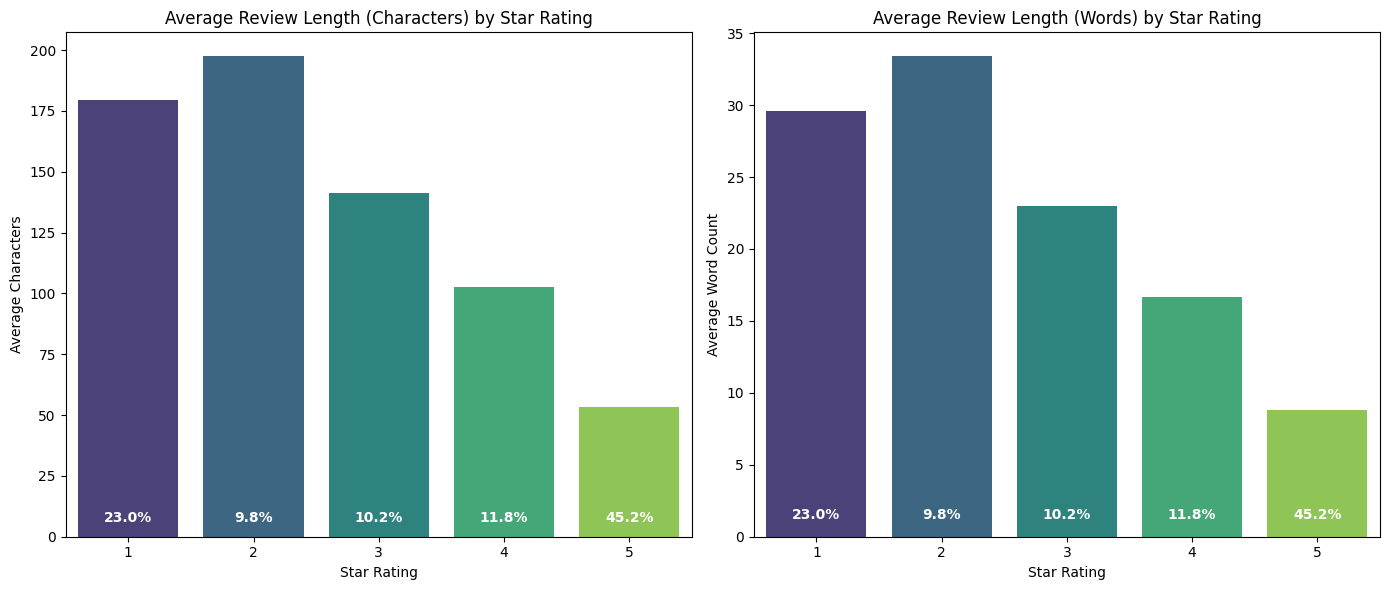

   score  review_length_chars  review_length_words  content  percentage
0      1           179.400000            29.600000      115        23.0
1      2           197.428571            33.387755       49         9.8
2      3           141.352941            23.000000       51        10.2
3      4           102.694915            16.661017       59        11.8
4      5            53.438053             8.809735      226        45.2


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the star rating is in the 'score' column and review text is in 'content'
# These are typical column names for Google Play Store reviews, but modify if yours are different

# Calculate the length of each review
df2['review_length_chars'] = df2['content'].str.len()
df2['review_length_words'] = df2['content'].str.split().str.len()

# Group by star rating and calculate average lengths
length_by_stars = df2.groupby('score').agg({
    'review_length_chars': 'mean',
    'review_length_words': 'mean',
    'content': 'count'  # Count number of reviews per star rating
}).reset_index()

# Calculate percentages
total_reviews = length_by_stars['content'].sum()
length_by_stars['percentage'] = (length_by_stars['content'] / total_reviews * 100).round(1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for character length
bars1 = sns.barplot(x='score', y='review_length_chars', data=length_by_stars, palette='viridis', ax=ax1)
ax1.set_title('Average Review Length (Characters) by Star Rating')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Average Characters')

# Add percentage labels inside bars at the bottom
for i, row in enumerate(length_by_stars.itertuples()):
    ax1.text(i, 5, f'{row.percentage}%', 
            ha='center', va='bottom', color='white', fontweight='bold')

# Plot for word count
bars2 = sns.barplot(x='score', y='review_length_words', data=length_by_stars, palette='viridis', ax=ax2)
ax2.set_title('Average Review Length (Words) by Star Rating')
ax2.set_xlabel('Star Rating')
ax2.set_ylabel('Average Word Count')

# Add percentage labels inside bars at the bottom
for i, row in enumerate(length_by_stars.itertuples()):
    ax2.text(i, 1, f'{row.percentage}%', 
            ha='center', va='bottom', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Print the actual values
print(length_by_stars[['score', 'review_length_chars', 'review_length_words', 'content', 'percentage']])

In [39]:
import nltk
import os

# Print the current NLTK data path
print(f"Current NLTK data path: {nltk.data.path}")

# Option 1: Specify a custom download directory
nltk_data_dir = os.path.expanduser('~/nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)
print(f"Downloading to {nltk_data_dir}")

# Download with explicit download_dir parameter
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)

# Add the custom directory to NLTK's search path
nltk.data.path.append(nltk_data_dir)

# Verify the resources are accessible
try:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    print(f"Successfully loaded {len(stop_words)} stopwords")
    
    from nltk.tokenize import word_tokenize
    test_tokenize = word_tokenize("This is a test sentence.")
    print(f"Tokenization test: {test_tokenize}")
    
    print("NLTK resources are now properly configured!")
except Exception as e:
    print(f"Error testing NLTK resources: {e}")

Current NLTK data path: ['/Users/nicolocampagnoli/nltk_data', '/Users/nicolocampagnoli/miniconda3/envs/SentiNext/nltk_data', '/Users/nicolocampagnoli/miniconda3/envs/SentiNext/share/nltk_data', '/Users/nicolocampagnoli/miniconda3/envs/SentiNext/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/Users/nicolocampagnoli/nltk_data']
Successfully loaded 198 stopwords
Tokenization test: ['This', 'is', 'a', 'test', 'sentence', '.']
NLTK resources are now properly configured!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolocampagnoli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolocampagnoli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating improved summaries for 27 topics...


Processing Topics:   0%|          | 0/27 [00:00<?, ?it/s]


TOPIC: UI/UX
Average Rating: 3.56/5.0  |  Review Count: 380
Sentiment: negative: 37.4% | neutral: 33.9% | positive: 28.7%
Top Keywords: review, translate, provide, original, note, ready, good, tone, like, great, translation, sentiment, works, german, vehicle
Common Phrases: german review, original review, original sentiment, technical terms, go ahead, every time, natural english, terms related, fluent natural, original tone

Summary:
Users of the BMW Connected app generally praise its simplicity and ease of use, with many commenting on the accessibility of important car information. However, some users have expressed frustration with technical issues, such as crashes and compatibility problems with their vehicle's software updates. The app's UI/UX has received mixed reviews, with some users finding it too basic or simplistic.

Issues:
1. Technical issues: Crashes at startup, incompatibility with vehicle software updates, Bluetooth connectivity problems.
2. Limited settings options: So

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_69536/2484276067.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Average Rating', y='Topic', data=topic_df.sort_values('Average Rating'),


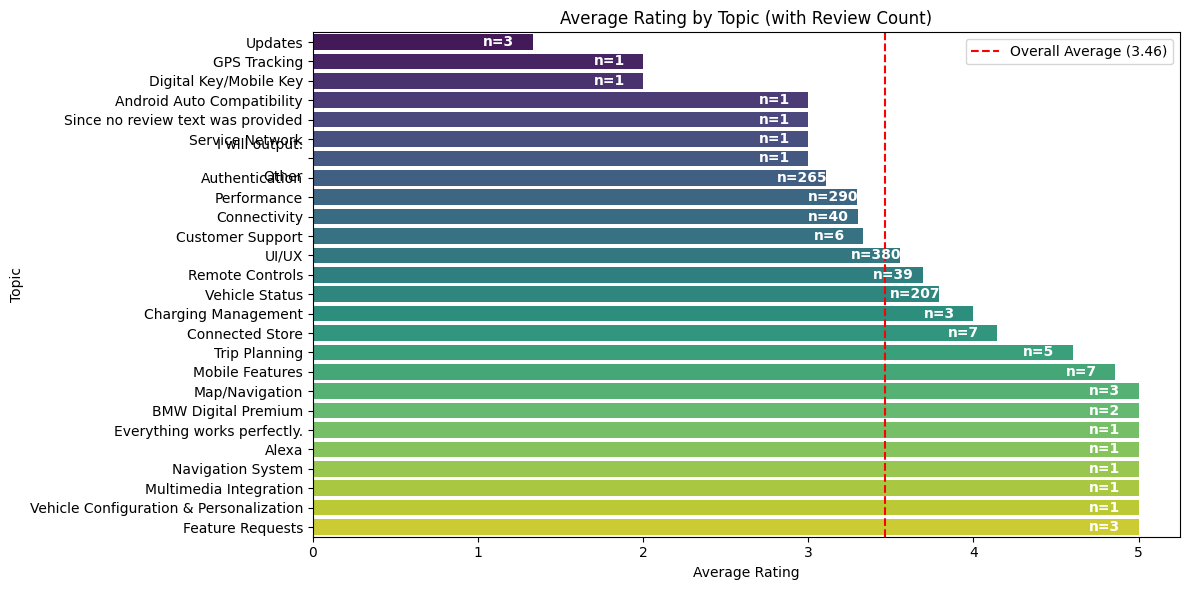

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from tqdm.notebook import tqdm
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def generate_topic_summaries_improved():
    """Generate topic summaries with stratified sampling and keyword extraction"""
    
    # Extract all unique topics
    all_topics = []
    for topic_list in df2['topics']:
        if isinstance(topic_list, str):  # Check if it's a string to avoid errors
            topics = [t.strip() for t in topic_list.split(',')]
            all_topics.extend(topics)
    
    unique_topics = pd.Series(all_topics).value_counts().index.tolist()
    
    print(f"Generating improved summaries for {len(unique_topics)} topics...")
    
    # Setup stopwords for keyword extraction
    stop_words = set(stopwords.words('english'))
    custom_stops = {'app', 'bmw', 'car', 'please', 'would', 'also', 'get', 'use', 'using'}
    stop_words.update(custom_stops)
    
    topic_summaries = {}
    for topic in tqdm(unique_topics, desc="Processing Topics"):
        # Skip 'Other' category
        if topic.lower() == 'other':
            continue
            
        # Get reviews for this topic
        topic_reviews = df2[df2['topics'].str.contains(topic, na=False)]
        
        if len(topic_reviews) == 0:
            continue
            
        # Calculate statistics
        avg_rating = topic_reviews['score'].mean()
        
        # Check if 'sentiment' column exists
        if 'sentiment' not in df2.columns:
            sentiment_dist = {"Not available": 1.0}
        else:
            sentiment_dist = topic_reviews['sentiment'].value_counts(normalize=True).to_dict()
        
        # 1. STRATIFIED SAMPLING: Sample reviews across star ratings
        sampled_reviews = []
        
        # Get distribution of star ratings for this topic
        rating_counts = topic_reviews['score'].value_counts().sort_index()
        
        # Define how many samples we want from each rating (max 10 total)
        total_desired = min(10, len(topic_reviews))
        
        # Calculate samples per rating to maintain proportions
        rating_proportions = rating_counts / rating_counts.sum()
        samples_per_rating = (rating_proportions * total_desired).round().astype(int)
        
        # Adjust to ensure we get exactly total_desired samples
        while samples_per_rating.sum() > total_desired:
            samples_per_rating[samples_per_rating.idxmax()] -= 1
        while samples_per_rating.sum() < total_desired:
            samples_per_rating[samples_per_rating.idxmin()] += 1
        
        # Sample reviews for each rating
        for rating, n_samples in samples_per_rating.items():
            if n_samples > 0:
                rating_reviews = topic_reviews[topic_reviews['score'] == rating]
                sampled = rating_reviews.sample(min(n_samples, len(rating_reviews)))
                sampled_reviews.append(sampled)
        
        # Combine all sampled reviews
        if sampled_reviews:
            sampled_df = pd.concat(sampled_reviews)
            # Use the translated English content
            review_texts = sampled_df['content_english'].tolist()
        else:
            review_texts = []
        
        # 2. KEYWORD EXTRACTION: Find most common important words/phrases
        # Use the translated English content for all reviews in this topic
        all_text = " ".join(topic_reviews['content_english'].fillna("").tolist()).lower()
        
        # Clean and tokenize
        words = word_tokenize(all_text)
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
        
        # Get most common words
        word_counts = Counter(filtered_words).most_common(15)
        top_keywords = [word for word, count in word_counts]
        
        # Find common bigrams/phrases
        text_tokens = [t.lower() for t in word_tokenize(all_text) if t.isalpha()]
        bigrams = list(zip(text_tokens, text_tokens[1:]))
        filtered_bigrams = [f"{b[0]} {b[1]}" for b in bigrams 
                           if b[0] not in stop_words and b[1] not in stop_words]
        
        # Get most common bigrams
        bigram_counts = Counter(filtered_bigrams).most_common(10)
        top_bigrams = [bigram for bigram, count in bigram_counts]
        
        # Generate summary with LLM, including keywords and rating distribution
        summary_prompt = f"""You are analyzing user reviews of the BMW Connected app on the topic '{topic}'.

STATISTICAL CONTEXT:
- Average Rating: {avg_rating:.2f}/5.0 from {len(topic_reviews)} reviews
- Rating Distribution: {dict(rating_counts)}
- Most Common Keywords: {', '.join(top_keywords)}
- Common Phrases: {', '.join(top_bigrams)}

Below are representative reviews selected across different star ratings:
{' '.join([f'[{idx+1}] "{text}"' for idx, text in enumerate(review_texts)])}

Please provide:
1. A concise summary (3-5 sentences) of what users are saying about this topic
2. The main issues/complaints (if any)
3. The main positive aspects (if any)

Format your response as:
Summary: [summary]
Issues: [issue 1], [issue 2], ...
Positives: [positive 1], [positive 2], ...
"""
        
        process = subprocess.run(
            ["ollama", "run", ollama_model_name],
            input=summary_prompt,
            text=True,
            capture_output=True
        )
        
        # Store results
        topic_summaries[topic] = {
            'summary': process.stdout.strip(),
            'avg_rating': avg_rating,
            'review_count': len(topic_reviews),
            'sentiment_dist': sentiment_dist,
            'top_keywords': top_keywords,
            'top_bigrams': top_bigrams
        }
    
    # Display summaries in a readable format
    for topic, data in topic_summaries.items():
        print(f"\n{'='*70}")
        print(f"TOPIC: {topic}")
        print(f"{'='*70}")
        print(f"Average Rating: {data['avg_rating']:.2f}/5.0  |  Review Count: {data['review_count']}")
        
        # Format sentiment distribution
        sentiment_str = " | ".join([f"{k}: {v*100:.1f}%" for k, v in data['sentiment_dist'].items()])
        print(f"Sentiment: {sentiment_str}")
        
        # Display top keywords and phrases
        print(f"Top Keywords: {', '.join(data['top_keywords'])}")
        print(f"Common Phrases: {', '.join(data['top_bigrams'])}")
        
        print(f"\n{data['summary']}")
    
    return topic_summaries

# Generate improved topic summaries
improved_topic_summaries = generate_topic_summaries_improved()

# Visualize average ratings by topic with review counts
topic_data = [(topic, data['avg_rating'], data['review_count']) 
              for topic, data in improved_topic_summaries.items()]
topic_df = pd.DataFrame(topic_data, columns=['Topic', 'Average Rating', 'Review Count'])

plt.figure(figsize=(12, 6))
bars = sns.barplot(x='Average Rating', y='Topic', data=topic_df.sort_values('Average Rating'),
                  palette='viridis')

# Add review count annotations to bars
for i, (_, row) in enumerate(topic_df.sort_values('Average Rating').iterrows()):
    bars.text(row['Average Rating'] - 0.3, i, f"n={row['Review Count']}", 
              va='center', color='white', fontweight='bold')

plt.axvline(x=df2['score'].mean(), color='red', linestyle='--', 
           label=f'Overall Average ({df2["score"].mean():.2f})')
plt.title('Average Rating by Topic (with Review Count)')
plt.legend()
plt.tight_layout()
plt.show()

Found 27 major.minor app versions after grouping
Top 5 topics in your data: ['UI/UX', 'Performance', 'Authentication', 'Vehicle Status', 'Connectivity']


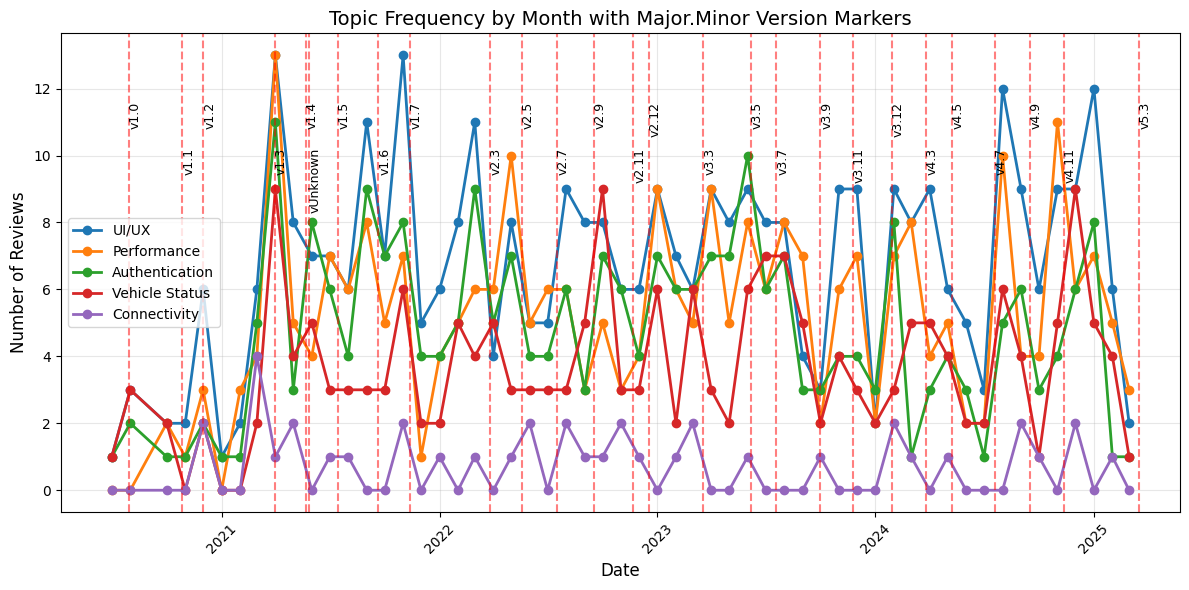

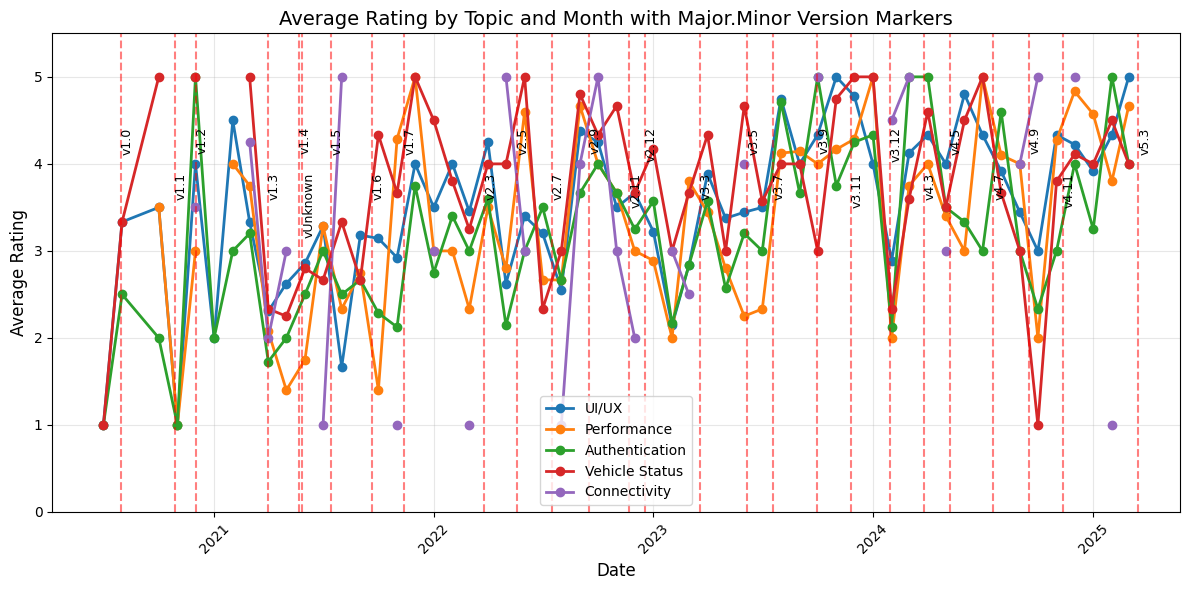

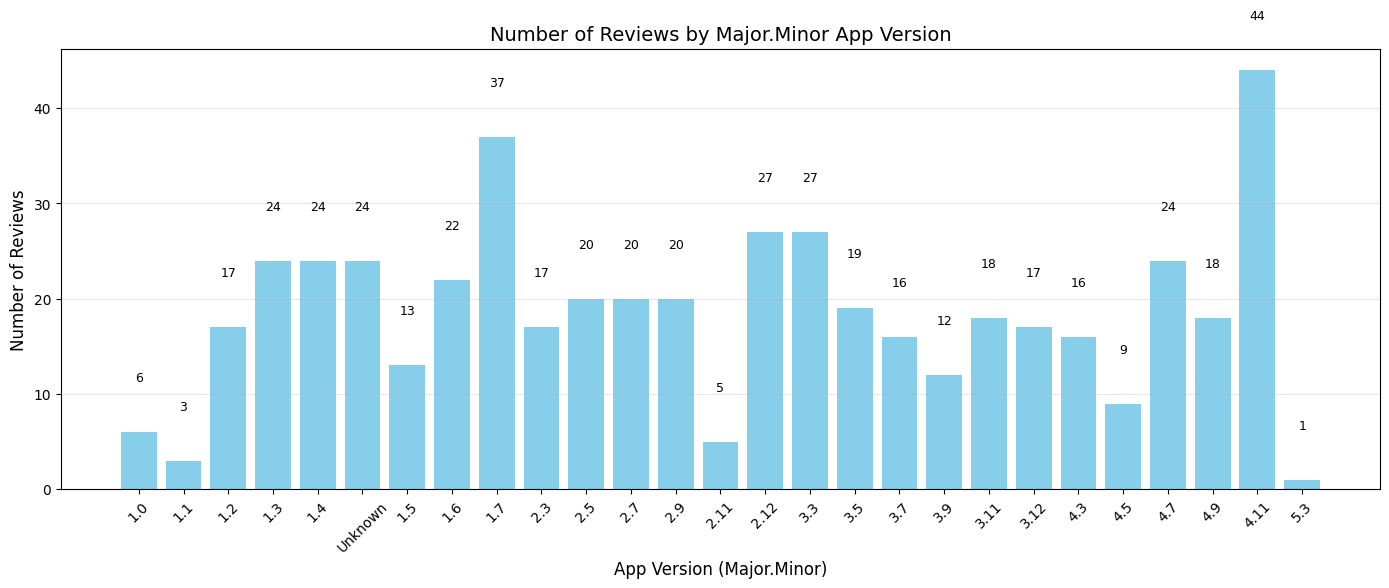

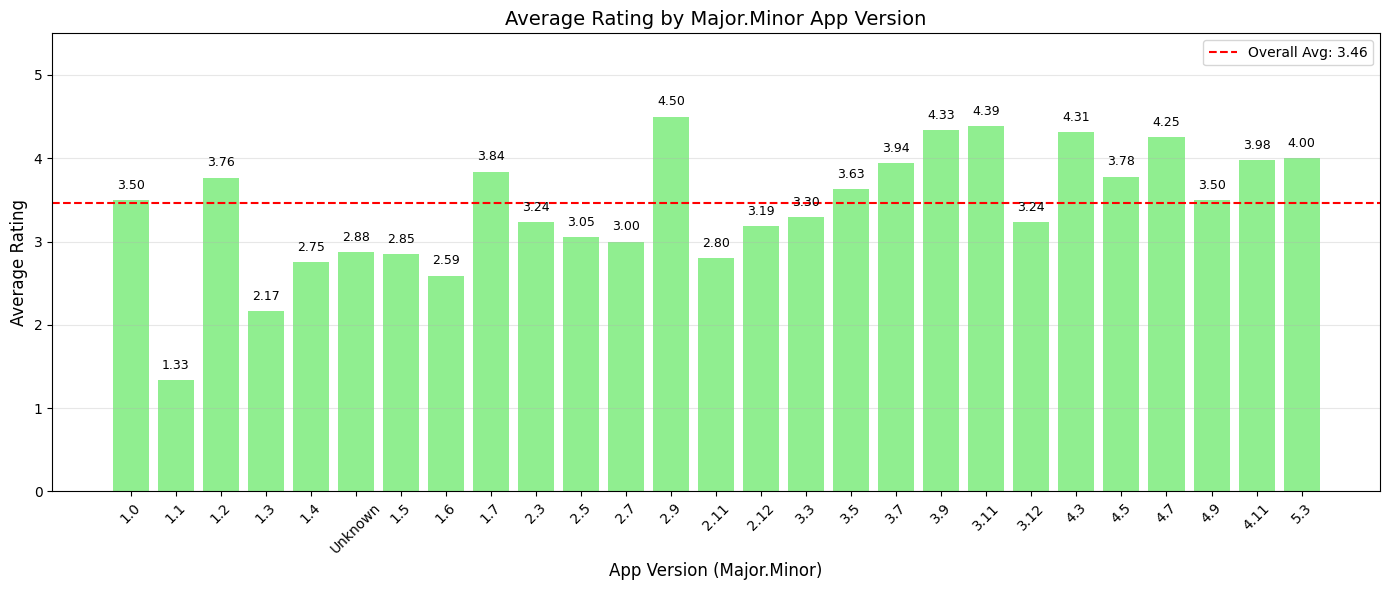

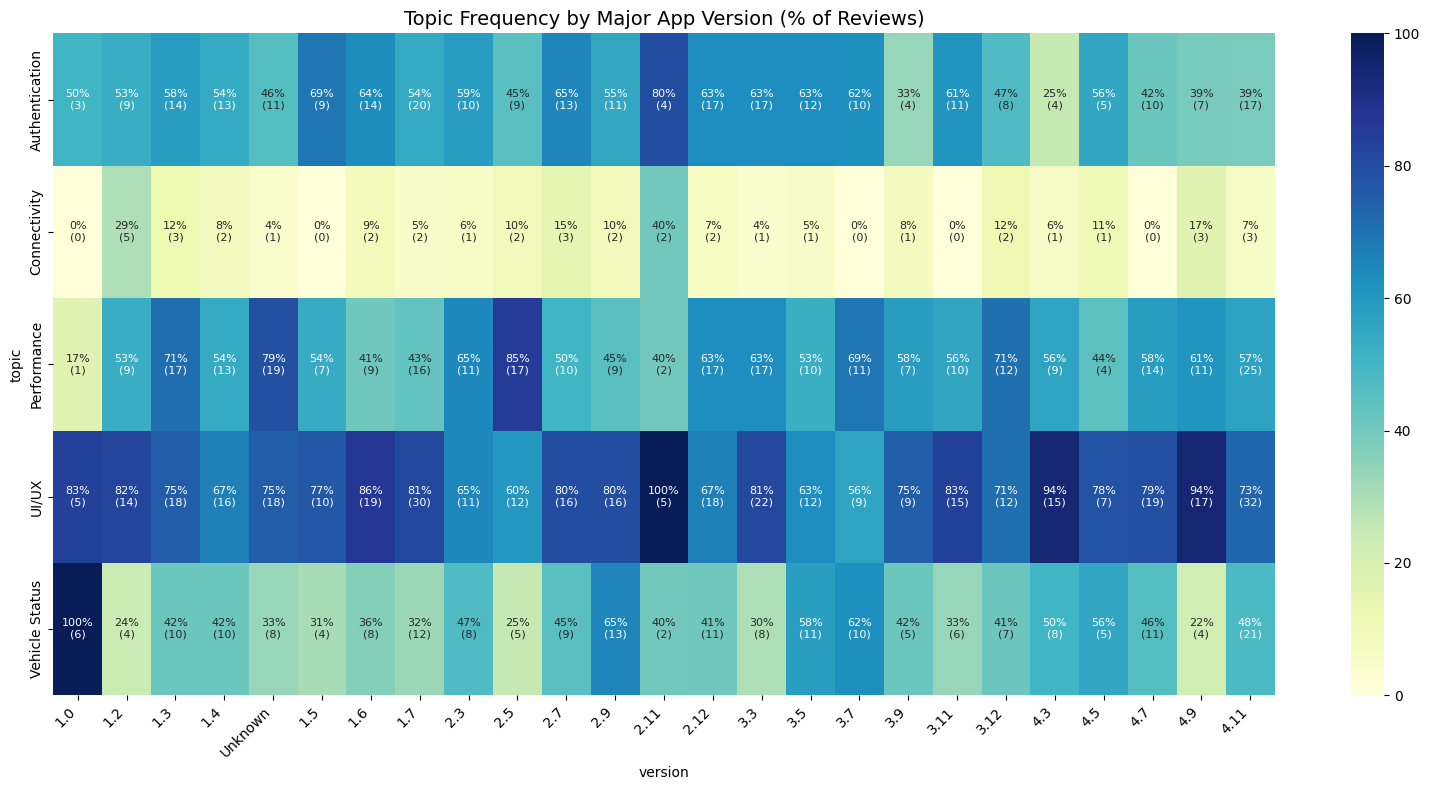

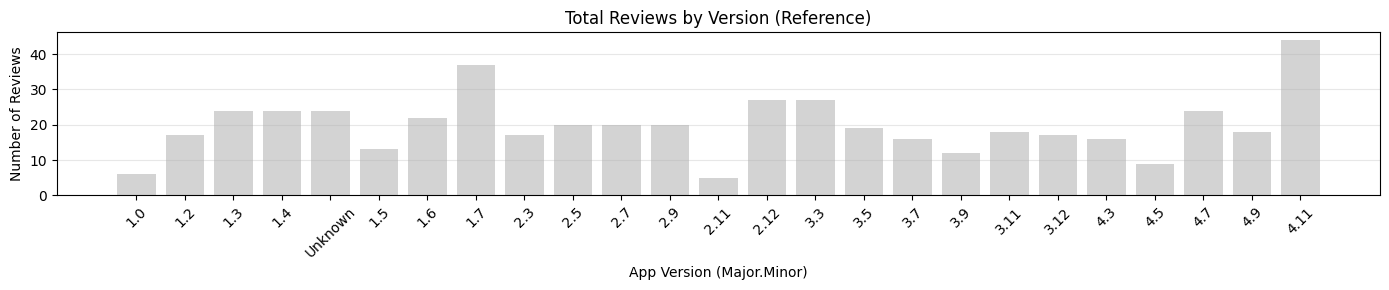

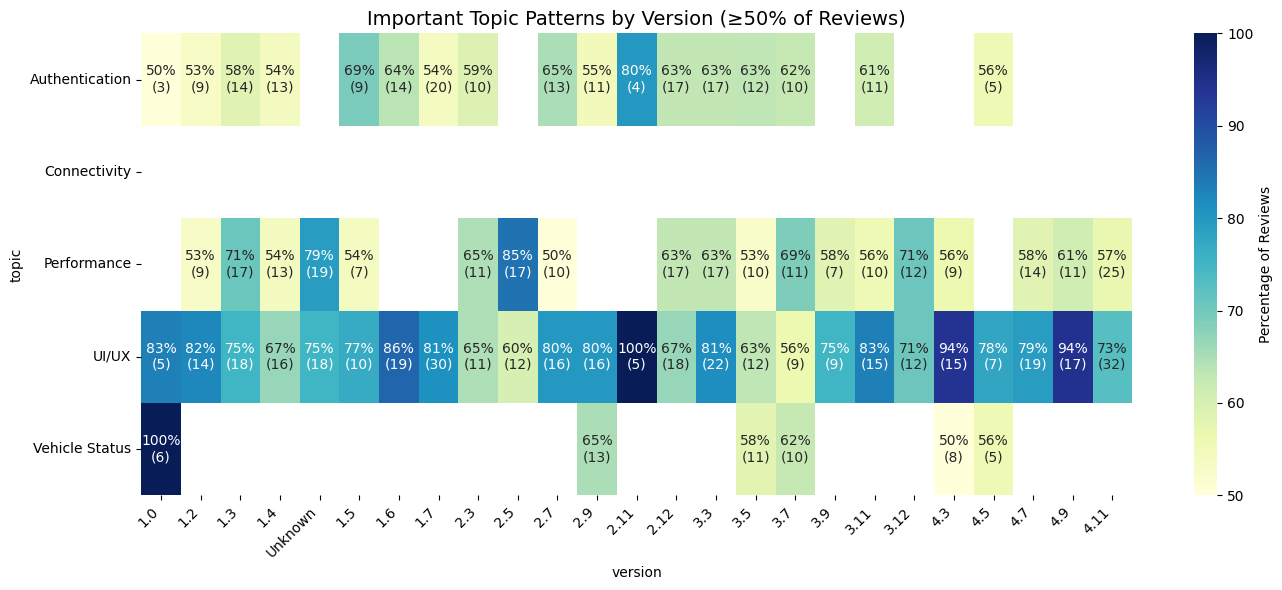

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from datetime import datetime

def plot_topics_with_grouped_versions():
    """
    Plot the frequency and sentiment of top topics over time with app versions
    grouped by major.minor (ignoring patch versions), with improved visualizations.
    """
    # Make sure we have a datetime column
    df2['date'] = pd.to_datetime(df2['at'])
    
    # Extract and group app versions by major.minor
    if 'appVersion' not in df2.columns:
        print("Warning: 'appVersion' column not found in data")
        grouped_versions_available = False
    else:
        # Fill NA values
        df2['appVersion'] = df2['appVersion'].fillna('Unknown')
        
        # Create a new column with grouped versions (major.minor)
        def extract_major_minor(version):
            # Match pattern like "3.7.2" and extract "3.7"
            match = re.match(r'(\d+\.\d+)', str(version))
            if match:
                return match.group(1)
            else:
                return version
        
        df2['groupedVersion'] = df2['appVersion'].apply(extract_major_minor)
        
        # Get first appearance date of each grouped version
        version_dates = df2.groupby('groupedVersion')['date'].min().reset_index()
        version_dates = version_dates.sort_values('date')
        
        grouped_versions_available = True
        print(f"Found {len(version_dates)} major.minor app versions after grouping")
    
    # Group by month
    df2['yearmonth'] = df2['date'].dt.to_period('M')
    
    # Extract topics and find top 5
    all_topics = []
    for topic_list in df2['topics'].dropna():
        if isinstance(topic_list, str):
            topics = [t.strip() for t in topic_list.split(',')]
            all_topics.extend(topics)
    
    # Get the top 5 topics from your data
    top_topics = pd.Series(all_topics).value_counts().head(5).index.tolist()
    print(f"Top 5 topics in your data: {top_topics}")
    
    # Prepare data for monthly analysis
    monthly_data = []
    
    for period in sorted(df2['yearmonth'].unique()):
        period_start = period.start_time
        period_reviews = df2[df2['yearmonth'] == period]
        
        for topic in top_topics:
            # Get reviews mentioning this topic in this time period
            topic_reviews = period_reviews[period_reviews['topics'].str.contains(topic, na=False)]
            count = len(topic_reviews)
            
            # Calculate average rating for this topic/period
            avg_rating = topic_reviews['score'].mean() if len(topic_reviews) > 0 else np.nan
            
            monthly_data.append({
                'date': period_start,
                'topic': topic,
                'count': count,
                'avg_rating': avg_rating
            })
    
    monthly_df = pd.DataFrame(monthly_data)
    
    # Plot 1: Topic frequency over time with app version markers
    plt.figure(figsize=(12, 6))
    
    # First plot the frequency lines
    for topic in top_topics:
        topic_data = monthly_df[monthly_df['topic'] == topic]
        plt.plot(topic_data['date'], topic_data['count'], marker='o', linewidth=2, label=topic)
    
    # Then add app version markers
    if grouped_versions_available:
        # Since we've grouped versions, we should have fewer now
        for i, (update_date, version) in enumerate(zip(version_dates['date'], version_dates['groupedVersion'])):
            plt.axvline(x=update_date, color='red', linestyle='--', alpha=0.5)
            # Place text alternating high/low to avoid overlap
            y_pos = 0.85 if i % 2 == 0 else 0.75
            plt.text(update_date, plt.ylim()[1] * y_pos, f"v{version}", 
                     rotation=90, va='top', fontsize=9)
    
    plt.title('Topic Frequency by Month with Major.Minor Version Markers', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Ratings over time with app version markers
    plt.figure(figsize=(12, 6))
    
    # First plot the rating lines
    for topic in top_topics:
        topic_data = monthly_df[monthly_df['topic'] == topic]
        plt.plot(topic_data['date'], topic_data['avg_rating'], marker='o', linewidth=2, label=topic)
    
    # Then add app version markers
    if grouped_versions_available:
        for i, (update_date, version) in enumerate(zip(version_dates['date'], version_dates['groupedVersion'])):
            plt.axvline(x=update_date, color='red', linestyle='--', alpha=0.5)
            y_pos = 0.85 if i % 2 == 0 else 0.75
            plt.text(update_date, plt.ylim()[1] * y_pos, f"v{version}", 
                     rotation=90, va='top', fontsize=9)
    
    plt.title('Average Rating by Topic and Month with Major.Minor Version Markers', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Rating', fontsize=12)
    plt.ylim(0, 5.5)  # Assuming 5-star rating system
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot 3 and 4: Version analyses
    if grouped_versions_available:
        # Count reviews per grouped version
        version_counts = df2['groupedVersion'].value_counts().reset_index()
        version_counts.columns = ['groupedVersion', 'count']
        
        # Merge with version dates
        version_info = pd.merge(version_dates, version_counts, on='groupedVersion')
        version_info = version_info.sort_values('date')
        
        plt.figure(figsize=(14, 6))
        
        # Create bar chart of reviews per version
        bars = plt.bar(version_info['groupedVersion'], version_info['count'], color='skyblue')
        
        # Add count labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        plt.title('Number of Reviews by Major.Minor App Version', fontsize=14)
        plt.xlabel('App Version (Major.Minor)', fontsize=12)
        plt.ylabel('Number of Reviews', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Plot 4: Average rating by grouped app version
        version_ratings = df2.groupby('groupedVersion')['score'].mean().reset_index()
        version_ratings = pd.merge(version_info[['groupedVersion', 'date']], 
                                  version_ratings, on='groupedVersion')
        version_ratings = version_ratings.sort_values('date')
        
        plt.figure(figsize=(14, 6))
        bars = plt.bar(version_ratings['groupedVersion'], version_ratings['score'], color='lightgreen')
        
        # Add rating labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Add overall average line
        plt.axhline(y=df2['score'].mean(), color='red', linestyle='--', 
                   label=f'Overall Avg: {df2["score"].mean():.2f}')
        
        plt.title('Average Rating by Major.Minor App Version', fontsize=14)
        plt.xlabel('App Version (Major.Minor)', fontsize=12)
        plt.ylabel('Average Rating', fontsize=12)
        plt.ylim(0, 5.5)
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Bonus plot: Topic frequency by app version (in percentages) - IMPROVED VERSION
        # Prepare data for percentage-based visualization
        version_topic_data = []
        
        for version in df2['groupedVersion'].unique():
            version_reviews = df2[df2['groupedVersion'] == version]
            total_reviews_for_version = len(version_reviews)
            
            for topic in top_topics:
                # Count reviews for this topic and version
                topic_reviews = version_reviews[version_reviews['topics'].str.contains(topic, na=False)]
                count = len(topic_reviews)
                
                # Calculate percentage of reviews for this version that mention this topic
                if total_reviews_for_version > 0:
                    percentage = (count / total_reviews_for_version) * 100
                else:
                    percentage = 0
                
                version_topic_data.append({
                    'version': version,
                    'topic': topic,
                    'count': count,
                    'percentage': percentage,
                    'total_reviews': total_reviews_for_version
                })
        
        version_topic_df = pd.DataFrame(version_topic_data)
        
        # Get ordered versions
        ordered_versions = version_dates['groupedVersion'].tolist()
        
        # IMPROVEMENT 1: Filter to include only versions with significant number of reviews
        min_reviews_threshold = 5  # Adjust this number as needed
        significant_versions = version_topic_df.groupby('version')['total_reviews'].first()
        significant_versions = significant_versions[significant_versions >= min_reviews_threshold]
        filtered_versions = [v for v in ordered_versions if v in significant_versions.index]
        
        # Pivot data for heatmap
        heatmap_data = version_topic_df.pivot(index='topic', columns='version', values='percentage')
        heatmap_data = heatmap_data[filtered_versions]
        
        # IMPROVEMENT 2: Simplified annotations
        # Format as percentage only, with count in parentheses for clarity
        annotations = np.empty_like(heatmap_data.values, dtype=object)
        
        for i, topic in enumerate(heatmap_data.index):
            for j, version in enumerate(heatmap_data.columns):
                val = heatmap_data.iloc[i, j]
                count = version_topic_df[(version_topic_df['topic'] == topic) & 
                                        (version_topic_df['version'] == version)]['count'].values[0]
                
                # More compact label format
                annotations[i, j] = f"{val:.0f}%\n({count})"
        
        # IMPROVEMENT 3: Better sizing and layout
        plt.figure(figsize=(16, 8))  # Wider aspect ratio
        
        # Create heatmap with improved formatting
        ax = sns.heatmap(heatmap_data, annot=annotations, fmt='', cmap='YlGnBu',
                        annot_kws={'size': 8, 'weight': 'normal'})  # Smaller font
        
        # IMPROVEMENT 4: Better labels and title
        plt.title('Topic Frequency by Major App Version (% of Reviews)', fontsize=14)
        
        # IMPROVEMENT 5: Rotate column labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # IMPROVEMENT 6: Add gridlines to separate cells more clearly
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # The reference bar chart showing the number of reviews per version
        plt.figure(figsize=(14, 3))
        version_counts = version_topic_df[['version', 'total_reviews']].drop_duplicates()
        version_counts = version_counts[version_counts['version'].isin(filtered_versions)]
        version_counts = version_counts.set_index('version').reindex(filtered_versions).reset_index()
        
        plt.bar(version_counts['version'], version_counts['total_reviews'], color='lightgray')
        plt.title('Total Reviews by Version (Reference)', fontsize=12)
        plt.xlabel('App Version (Major.Minor)', fontsize=10)
        plt.ylabel('Number of Reviews', fontsize=10)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # BONUS PLOT: A filtered "highlights" heatmap showing only important patterns
        plt.figure(figsize=(14, 6))
        
        # Create a mask that only shows values above a threshold
        highlight_threshold = 50  # Only show cells with percentage >= 50%
        mask = heatmap_data < highlight_threshold
        
        # Use the mask to hide less significant values
        ax = sns.heatmap(heatmap_data, annot=annotations, fmt='', mask=mask, 
                         cmap='YlGnBu', cbar_kws={'label': 'Percentage of Reviews'})
        
        plt.title('Important Topic Patterns by Version (≥50% of Reviews)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Run the analysis
plot_topics_with_grouped_versions()

Found 27 unique topics in your data
After filtering, showing 15 topics that appear in at least 3 reviews


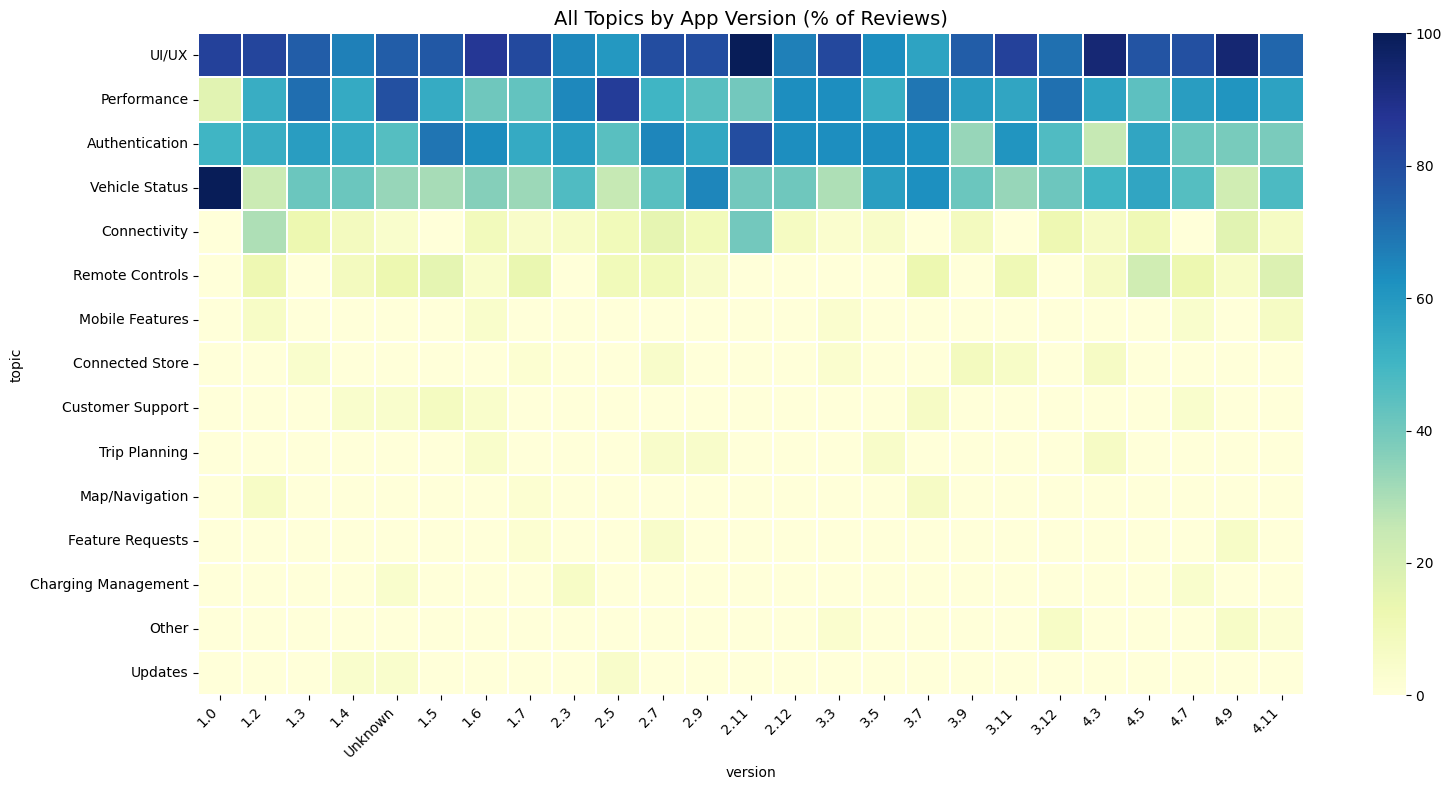

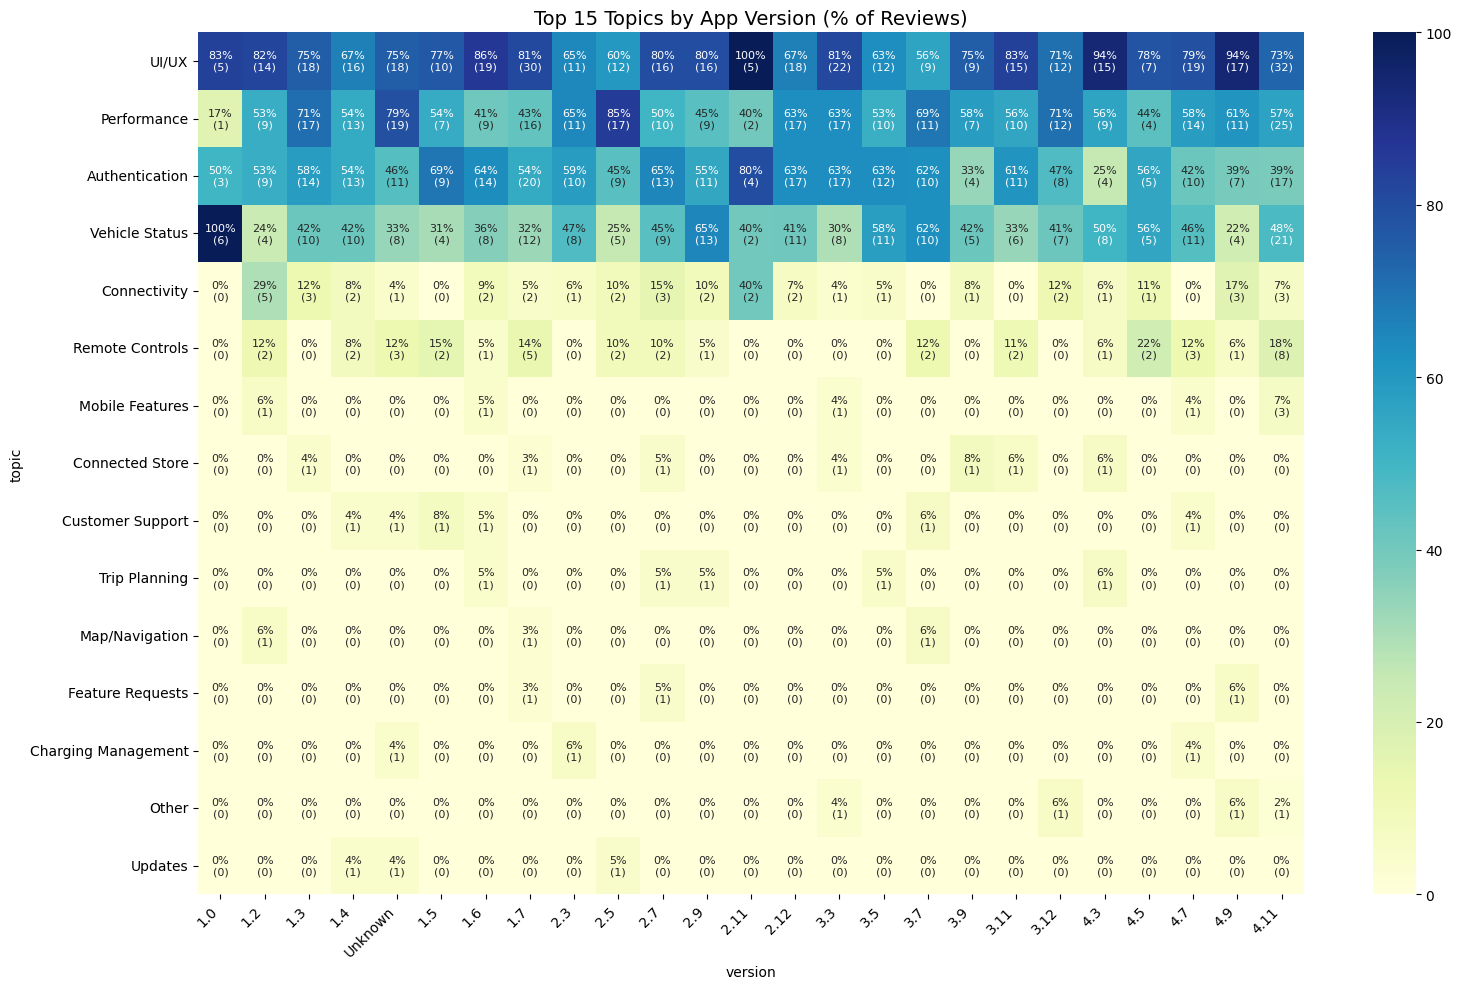


Topic Summary (sorted by total mentions):
                         Topic  Total Mentions  Average %
23                       UI/UX             380  75.028533
18                 Performance             290  58.218046
2               Authentication             265  55.982239
26              Vehicle Status             207  44.077784
6                 Connectivity              40   8.411433
19             Remote Controls              39   6.643049
14             Mobile Features               7   0.930236
5              Connected Store               7   1.322665
7             Customer Support               6   1.147695
22               Trip Planning               5   0.965134
17                       Other               4   0.644976
24                     Updates               3   0.493827
13              Map/Navigation               3   0.549447
10            Feature Requests               3   0.491047
4          Charging Management               3   0.526507
3          BMW Digital Premiu

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from datetime import datetime

def plot_all_topics_by_version():
    """
    Create a heatmap showing ALL topics across app versions.
    """
    # Make sure we have a datetime column
    df2['date'] = pd.to_datetime(df2['at'])
    
    # Extract and group app versions by major.minor
    if 'appVersion' not in df2.columns:
        print("Warning: 'appVersion' column not found in data")
        return
        
    # Fill NA values
    df2['appVersion'] = df2['appVersion'].fillna('Unknown')
    
    # Create a new column with grouped versions (major.minor)
    def extract_major_minor(version):
        # Match pattern like "3.7.2" and extract "3.7"
        match = re.match(r'(\d+\.\d+)', str(version))
        if match:
            return match.group(1)
        else:
            return version
    
    df2['groupedVersion'] = df2['appVersion'].apply(extract_major_minor)
    
    # Get first appearance date of each grouped version for ordering
    version_dates = df2.groupby('groupedVersion')['date'].min().reset_index()
    version_dates = version_dates.sort_values('date')
    ordered_versions = version_dates['groupedVersion'].tolist()
    
    # Extract ALL unique topics
    all_topics = []
    for topic_list in df2['topics'].dropna():
        if isinstance(topic_list, str):
            topics = [t.strip() for t in topic_list.split(',')]
            all_topics.extend(topics)
    
    # Get counts for all topics (to sort by popularity)
    topic_counts = pd.Series(all_topics).value_counts()
    all_unique_topics = topic_counts.index.tolist()
    
    print(f"Found {len(all_unique_topics)} unique topics in your data")
    
    # Prepare data for visualization
    version_topic_data = []
    
    for version in df2['groupedVersion'].unique():
        version_reviews = df2[df2['groupedVersion'] == version]
        total_reviews_for_version = len(version_reviews)
        
        for topic in all_unique_topics:
            # Count reviews for this topic and version
            topic_reviews = version_reviews[version_reviews['topics'].str.contains(topic, na=False)]
            count = len(topic_reviews)
            
            # Calculate percentage of reviews for this version that mention this topic
            if total_reviews_for_version > 0:
                percentage = (count / total_reviews_for_version) * 100
            else:
                percentage = 0
            
            version_topic_data.append({
                'version': version,
                'topic': topic,
                'count': count,
                'percentage': percentage,
                'total_reviews': total_reviews_for_version
            })
    
    version_topic_df = pd.DataFrame(version_topic_data)
    
    # Filter to include only versions with significant number of reviews
    min_reviews_threshold = 5  # Adjust this number as needed
    significant_versions = version_topic_df.groupby('version')['total_reviews'].first()
    significant_versions = significant_versions[significant_versions >= min_reviews_threshold]
    filtered_versions = [v for v in ordered_versions if v in significant_versions.index]
    
    # Filter to include only topics that appear in at least some reviews
    topic_presence = version_topic_df.groupby('topic')['count'].sum()
    min_topic_presence = 3  # Minimum number of total reviews mentioning this topic
    significant_topics = topic_presence[topic_presence >= min_topic_presence].index.tolist()
    
    # Sort topics by popularity (most mentioned first)
    sorted_topics = [t for t in all_unique_topics if t in significant_topics]
    
    print(f"After filtering, showing {len(sorted_topics)} topics that appear in at least {min_topic_presence} reviews")
    
    # Pivot data for the full heatmap
    heatmap_data = version_topic_df.pivot(index='topic', columns='version', values='percentage')
    heatmap_data = heatmap_data.loc[sorted_topics, filtered_versions]
    
    # Create a more compact heatmap
    plt.figure(figsize=(16, max(8, len(sorted_topics) * 0.4)))  # Dynamic height based on topic count
    
    # Use a simpler heatmap without individual annotations (too many cells)
    sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.1)
    
    plt.title('All Topics by App Version (% of Reviews)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create a second heatmap with only the most frequently mentioned topics (top 15)
    top_n = 15  # Adjust as needed
    top_topics = sorted_topics[:top_n]
    
    # Create a smaller heatmap with annotations for the top topics
    heatmap_top_data = heatmap_data.loc[top_topics]
    
    # Create annotations for the top topics
    annotations = np.empty_like(heatmap_top_data.values, dtype=object)
    
    for i, topic in enumerate(heatmap_top_data.index):
        for j, version in enumerate(heatmap_top_data.columns):
            val = heatmap_top_data.iloc[i, j]
            count = version_topic_df[(version_topic_df['topic'] == topic) & 
                                    (version_topic_df['version'] == version)]['count'].values[0]
            
            # Compact label format
            annotations[i, j] = f"{val:.0f}%\n({count})"
    
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(heatmap_top_data, annot=annotations, fmt='', cmap='YlGnBu',
                    annot_kws={'size': 8})
    
    plt.title(f'Top {top_n} Topics by App Version (% of Reviews)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create an informative summary table of all topics
    topic_summary = version_topic_df.groupby('topic').agg({
        'count': 'sum',
        'percentage': 'mean'
    }).reset_index()
    
    topic_summary = topic_summary.sort_values('count', ascending=False)
    topic_summary.columns = ['Topic', 'Total Mentions', 'Average %']
    
    print("\nTopic Summary (sorted by total mentions):")
    print(topic_summary.head(20))  # Show top 20 topics
    
    return topic_summary  # Return this for further analysis if needed

# Run the analysis
all_topics_summary = plot_all_topics_by_version()

Found 25 languages in your data
Top 5 languages by review count: ['German', 'English', 'Italian', 'French', 'Spanish']


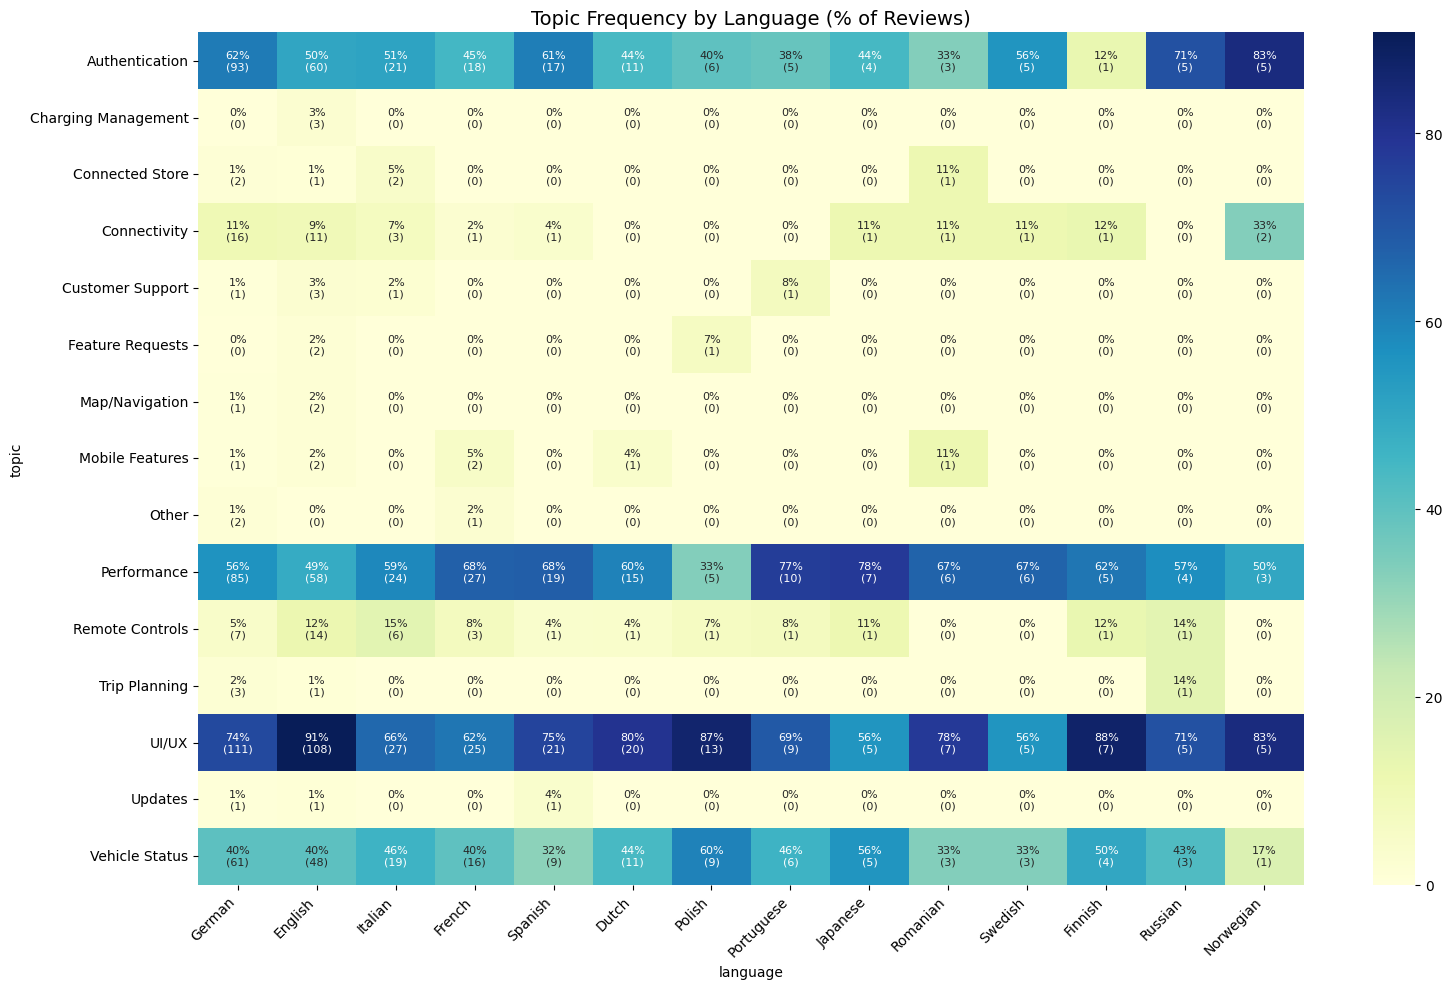

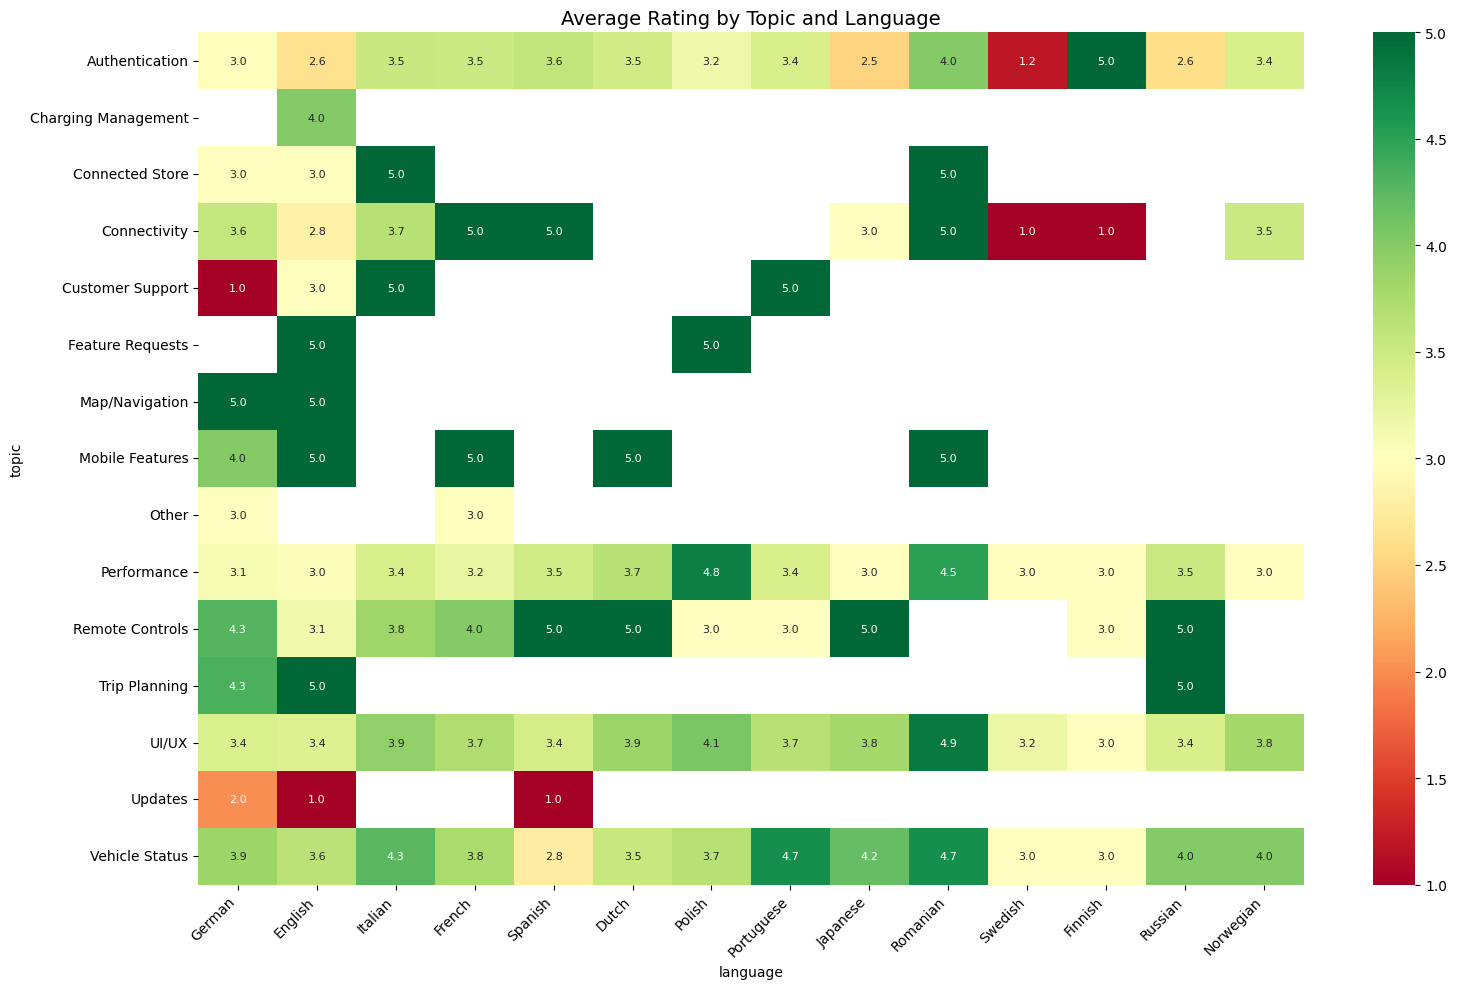

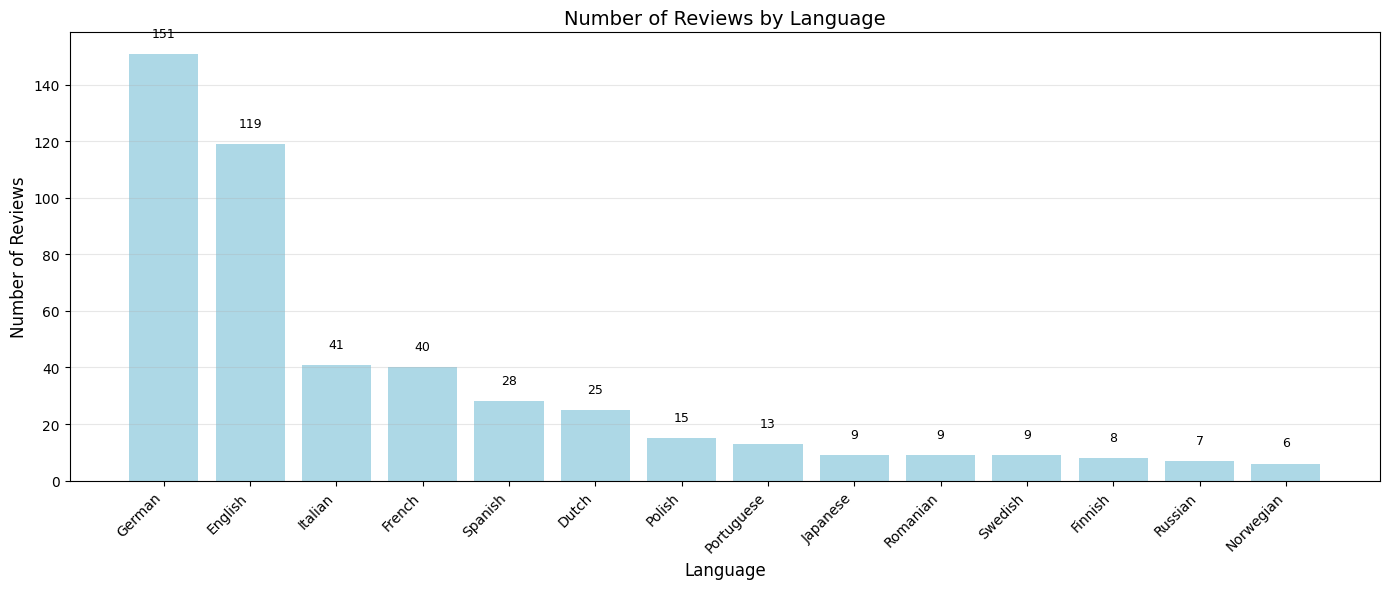

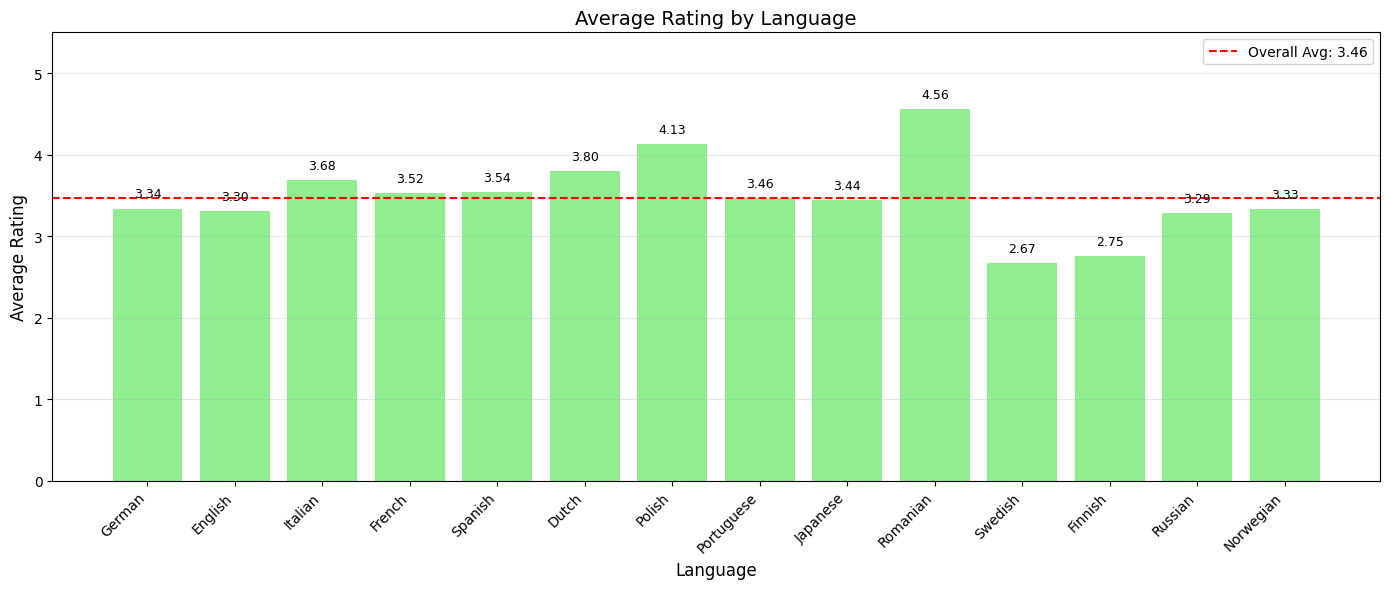

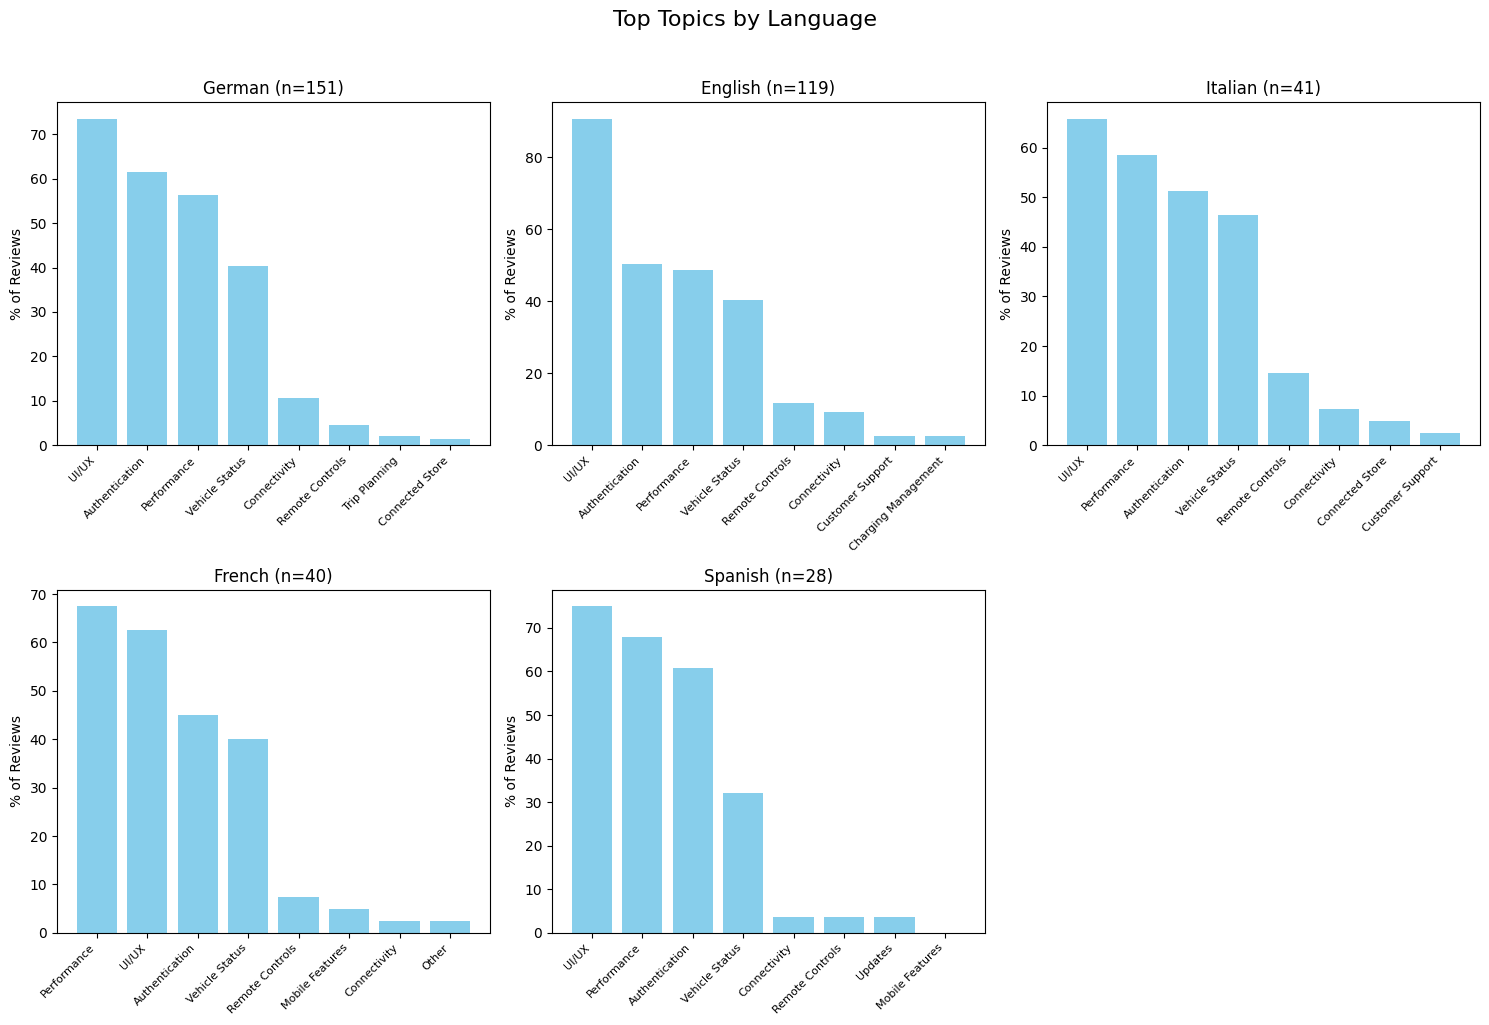

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

def analyze_topics_by_language():
    """
    Analyze and visualize topic distribution across different language regions.
    """
    # Check if language column exists
    if 'language' not in df2.columns:
        print("Error: 'language' column not found in data")
        return
        
    # Get language distribution
    language_counts = df2['language'].value_counts()
    print(f"Found {len(language_counts)} languages in your data")
    print(f"Top 5 languages by review count: {language_counts.head(5).index.tolist()}")
    
    # Extract all unique topics
    all_topics = []
    for topic_list in df2['topics'].dropna():
        if isinstance(topic_list, str):
            topics = [t.strip() for t in topic_list.split(',')]
            all_topics.extend(topics)
    
    # Get the top 15 topics
    top_topics = pd.Series(all_topics).value_counts().head(15).index.tolist()
    
    # Prepare data for language-topic analysis
    language_topic_data = []
    
    for language in df2['language'].unique():
        language_reviews = df2[df2['language'] == language]
        total_reviews_for_language = len(language_reviews)
        
        for topic in top_topics:
            # Count reviews for this topic and language
            topic_reviews = language_reviews[language_reviews['topics'].str.contains(topic, na=False)]
            count = len(topic_reviews)
            
            # Calculate average rating
            avg_rating = topic_reviews['score'].mean() if len(topic_reviews) > 0 else np.nan
            
            # Calculate percentage of reviews for this language that mention this topic
            if total_reviews_for_language > 0:
                percentage = (count / total_reviews_for_language) * 100
            else:
                percentage = 0
            
            language_topic_data.append({
                'language': language,
                'topic': topic,
                'count': count,
                'percentage': percentage,
                'avg_rating': avg_rating,
                'total_reviews': total_reviews_for_language
            })
    
    language_topic_df = pd.DataFrame(language_topic_data)
    
    # Filter to include only languages with significant number of reviews
    min_reviews_threshold = 5  # Adjust this number as needed
    significant_languages = language_topic_df.groupby('language')['total_reviews'].first()
    significant_languages = significant_languages[significant_languages >= min_reviews_threshold]
    filtered_languages = significant_languages.sort_values(ascending=False).index.tolist()
    
    # Take top 20 languages by review count to avoid overcrowding
    filtered_languages = filtered_languages[:20]
    
    # Pivot data for heatmap (topic frequency by language)
    heatmap_data = language_topic_df.pivot(index='topic', columns='language', values='percentage')
    heatmap_data = heatmap_data[filtered_languages]
    
    # Create annotations
    annotations = np.empty_like(heatmap_data.values, dtype=object)
    
    for i, topic in enumerate(heatmap_data.index):
        for j, language in enumerate(heatmap_data.columns):
            val = heatmap_data.iloc[i, j]
            count = language_topic_df[(language_topic_df['topic'] == topic) & 
                                     (language_topic_df['language'] == language)]['count'].values[0]
            
            # Compact label format
            annotations[i, j] = f"{val:.0f}%\n({count})"
    
    # Plot 1: Topic frequency by language
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(heatmap_data, annot=annotations, fmt='', cmap='YlGnBu',
                    annot_kws={'size': 8})
    
    plt.title('Topic Frequency by Language (% of Reviews)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Average rating by topic and language
    rating_heatmap = language_topic_df.pivot(index='topic', columns='language', values='avg_rating')
    rating_heatmap = rating_heatmap[filtered_languages]
    
    # Create rating annotations
    rating_annotations = np.empty_like(rating_heatmap.values, dtype=object)
    
    for i, topic in enumerate(rating_heatmap.index):
        for j, language in enumerate(rating_heatmap.columns):
            val = rating_heatmap.iloc[i, j]
            if not np.isnan(val):
                rating_annotations[i, j] = f"{val:.1f}"
            else:
                rating_annotations[i, j] = ""
    
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(rating_heatmap, annot=rating_annotations, fmt='', cmap='RdYlGn', 
                    vmin=1, vmax=5, annot_kws={'size': 8})
    
    plt.title('Average Rating by Topic and Language', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Review count by language (reference)
    plt.figure(figsize=(14, 6))
    language_reviews = df2['language'].value_counts().loc[filtered_languages]
    
    bars = plt.bar(language_reviews.index, language_reviews.values, color='lightblue')
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.title('Number of Reviews by Language', fontsize=14)
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Overall rating by language 
    plt.figure(figsize=(14, 6))
    language_ratings = df2.groupby('language')['score'].mean()
    language_ratings = language_ratings.loc[filtered_languages]
    
    bars = plt.bar(language_ratings.index, language_ratings.values, color='lightgreen')
    
    # Add rating labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Add overall average line
    plt.axhline(y=df2['score'].mean(), color='red', linestyle='--', 
               label=f'Overall Avg: {df2["score"].mean():.2f}')
    
    plt.title('Average Rating by Language', fontsize=14)
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Average Rating', fontsize=12)
    plt.ylim(0, 5.5)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Topic distribution for top languages
    # Get top 5 languages by review count
    top_languages = language_reviews.index[:5].tolist()
    
    plt.figure(figsize=(15, 10))
    
    for i, language in enumerate(top_languages):
        plt.subplot(2, 3, i+1)
        
        # Get topic distribution for this language
        language_topic_counts = language_topic_df[language_topic_df['language'] == language]
        language_topic_counts = language_topic_counts.sort_values('percentage', ascending=False)
        
        # Plot top 8 topics for this language
        plt.bar(language_topic_counts['topic'].head(8), 
               language_topic_counts['percentage'].head(8), 
               color='skyblue')
        
        plt.title(f'{language} (n={language_reviews[language]})')
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.ylabel('% of Reviews')
        plt.tight_layout()
    
    plt.suptitle('Top Topics by Language', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return language_topic_df  # Return for further analysis

# Run the analysis
language_topic_data = analyze_topics_by_language()

In [74]:
import time
import subprocess
import pandas as pd
import json
import re
from tqdm import tqdm
from sklearn.cluster import KMeans

USER_SEGMENTATION_PROMPT = """
You are a specialized BMW user-segmentation classifier analyzing app reviews.

INSTRUCTIONS:
1. Read the user's review carefully.
2. Determine THREE key aspects:

   A. VEHICLE TYPE (Powertrain):
      - "EV" = Electric Vehicle (mentions charging, battery, electric)
      - "ICE" = Internal Combustion (mentions fuel, gas, diesel)
      - "PHEV" = Plug-in Hybrid (mentions both charging and fuel)
      - "Unknown" if unclear

   B. VEHICLE SERIES:
      - "Premium" = 7/8 Series, X7, iX
      - "Sport" = M Series, M Performance vehicles
      - "Core" = 3/5 Series, X3/X5, i4
      - "Entry" = 1/2 Series, X1/X2, i3
      - "Unknown" if not mentioned

   C. TECHNICAL SOPHISTICATION (0-10 scale):
      0-3 = Basic user
          - Uses simple terms
          - Mentions basic app functions
          - No technical terminology
      
      4-7 = Intermediate user
          - Uses some technical terms
          - Discusses specific features
          - Shows familiarity with car systems
      
      8-10 = Advanced user
          - Uses technical terminology
          - Mentions advanced features
          - Shows deep system understanding

3. Return ONLY a JSON object with exactly these keys:
   {
     "powertrain": "...",
     "series": "...",
     "tech_score": ...
   }
"""

def classify_review_with_llm(review_text):
    """
    Use Ollama LLM to classify the review text across multiple segmentation dimensions
    """
    if not isinstance(review_text, str) or len(review_text.strip()) < 10:
        return {
            'powertrain': 'Unknown',
            'series': 'Unknown',
            'tech_score': 0
        }
    
    prompt = f"""{USER_SEGMENTATION_PROMPT}

BMW App Review: "{review_text}"

Respond ONLY with a valid JSON object containing powertrain, series, and tech_score. No other text."""
    
    try:
        # Call Ollama model
        process = subprocess.run(
            ["ollama", "run", ollama_model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        # Get the response and clean it
        response = process.stdout.strip()
        
        # Debug output (temporary)
        if not response:
            print(f"Empty response from LLM for review: {review_text[:100]}...")
            return {
                'powertrain': 'Unknown',
                'series': 'Unknown',
                'tech_score': 0
            }
        
        # Find JSON in the response
        json_match = re.search(r'({[^}]+})', response, re.DOTALL)
        if not json_match:
            print(f"No JSON found in response: {response[:100]}...")
            return {
                'powertrain': 'Unknown',
                'series': 'Unknown',
                'tech_score': 0
            }
            
        json_str = json_match.group(1)
        
        # Clean the JSON string
        json_str = json_str.replace('\n', ' ').replace('\r', '')
        json_str = re.sub(r'}\s*{', '}{', json_str)  # Remove spaces between multiple JSON objects
        
        # Parse the JSON
        classification = json.loads(json_str)
        
        # Validate the response
        required_keys = ['powertrain', 'series', 'tech_score']
        if not all(key in classification for key in required_keys):
            print(f"Missing required keys in response: {classification}")
            return {
                'powertrain': 'Unknown',
                'series': 'Unknown',
                'tech_score': 0
            }
        
        # Ensure tech_score is numeric
        try:
            classification['tech_score'] = float(classification['tech_score'])
        except (ValueError, TypeError):
            classification['tech_score'] = 0
            
        # Normalize values
        classification['powertrain'] = classification['powertrain'].strip().capitalize()
        classification['series'] = classification['series'].strip().capitalize()
        
        return classification
        
    except Exception as e:
        print(f"Error processing review: {str(e)}")
        print(f"Review text: {review_text[:100]}...")
        return {
            'powertrain': 'Unknown',
            'series': 'Unknown',
            'tech_score': 0
        }

def calculate_segment_metrics(df, segment_column):
    """Calculate metrics for a segment with error handling for column names"""
    metrics = pd.DataFrame()
    grouped = df.groupby(segment_column)
    
    # Calculate basic metrics
    counts = grouped.size()
    percentages = (counts / len(df) * 100)
    avg_scores = grouped['score'].mean()
    
    metrics['count'] = counts
    metrics['percent'] = percentages
    metrics['avg_rating'] = avg_scores
    
    return metrics

def bmw_user_segmentation_with_llm(df2, batch_size=10, max_retries=3):
    """
    Comprehensive user segmentation analysis for BMW app reviews using LLM classification.
    Includes progress tracking and error handling.
    """
    print("🚗 Starting BMW user segmentation analysis...")
    print(f"📊 Processing {len(df2)} reviews in batches of {batch_size}\n")
    
    # Step 1: Use LLM to classify reviews
    print("Classifying reviews with LLM (this may take some time)...")
    classifications = []
    
    # Process in batches with retry logic
    for idx, review in tqdm(df2['content_english'].items(), total=len(df2), 
                           desc="LLM Classification", unit="reviews"):
        
        retry_count = 0
        result = None
        
        while retry_count < max_retries and result is None:
            try:
                result = classify_review_with_llm(review)
                if result is None:
                    retry_count += 1
                    print(f"Retry {retry_count} for review {idx}")
                    time.sleep(1)  # Add delay between retries
            except Exception as e:
                print(f"Error on review {idx}: {str(e)}")
                retry_count += 1
                time.sleep(1)
        
        # If all retries failed, use default values
        if result is None:
            result = {
                'powertrain': 'Unknown',
                'series': 'Unknown',
                'tech_score': 0
            }
        
        classifications.append(result)
        
        # Add small delay between reviews to avoid rate limiting
        time.sleep(0.1)
    
    df2['user_signals'] = classifications
    
    # Step 2: Create segmentation columns from LLM classifications
    print("\nExtracting segments from classifications...")
    
    with tqdm(total=3, desc="Creating Segments", unit="segments") as pbar:
        # Extract powertrain type
        df2['segment_powertrain'] = df2['user_signals'].apply(lambda x: x['powertrain'])
        pbar.update(1)
        
        # Extract BMW series
        df2['segment_series'] = df2['user_signals'].apply(lambda x: x['series'])
        pbar.update(1)
        
        # Extract and categorize tech score
        df2['tech_score'] = df2['user_signals'].apply(lambda x: x['tech_score'])
        tech_bins = [0, 3, 7, float('inf')]
        tech_labels = ['basic', 'intermediate', 'advanced']
        df2['segment_tech'] = pd.cut(df2['tech_score'], bins=tech_bins, labels=tech_labels)
        pbar.update(1)
    
    # Calculate segment metrics
    print("\nCalculating segment metrics...")
    segment_analysis = {}
    
    segment_analysis['powertrain'] = {
        'column': 'segment_powertrain',
        'metrics': calculate_segment_metrics(df2, 'segment_powertrain')
    }
    
    segment_analysis['series'] = {
        'column': 'segment_series',
        'metrics': calculate_segment_metrics(df2, 'segment_series')
    }
    
    segment_analysis['tech_level'] = {
        'column': 'segment_tech',
        'metrics': calculate_segment_metrics(df2, 'segment_tech')
    }
    
    # Perform clustering for emergent segments
    print("\nIdentifying emergent user segments...")
    cluster_features = pd.get_dummies(df2[['segment_powertrain', 'segment_tech']])
    
    kmeans = KMeans(n_clusters=4, random_state=42)
    df2['cluster'] = kmeans.fit_predict(cluster_features)
    
    # Create cluster profiles
    cluster_profiles = {}
    for cluster in range(4):
        cluster_data = df2[df2['cluster'] == cluster]
        cluster_profiles[f'Segment_{cluster}'] = {
            'size': len(cluster_data),
            'percent': len(cluster_data) / len(df2) * 100,
            'avg_rating': cluster_data['score'].mean(),
            'dominant_powertrain': cluster_data['segment_powertrain'].mode()[0],
            'dominant_tech': cluster_data['segment_tech'].mode()[0],
            'dominant_series': cluster_data['segment_series'].mode()[0]
        }
    
    # Prepare results
    segmentation_results = {
        'segment_analysis': segment_analysis,
        'cluster_profiles': cluster_profiles,
        'total_reviews': len(df2)
    }
    
    # Print detailed analysis
    print("\n=== 📊 Segmentation Results ===")
    
    # 1. Powertrain Distribution
    print("\n1. Powertrain Distribution:")
    powertrain_metrics = segment_analysis['powertrain']['metrics']
    for idx in powertrain_metrics.index:
        print(f"   • {idx:<8}: {powertrain_metrics.loc[idx, 'percent']:>5.1f}% "
              f"({int(powertrain_metrics.loc[idx, 'count']):>4} reviews) "
              f"| Avg Rating: {powertrain_metrics.loc[idx, 'avg_rating']:.2f}⭐")
    
    # 2. Series Distribution
    print("\n2. Vehicle Series Distribution:")
    series_metrics = segment_analysis['series']['metrics']
    for idx in series_metrics.index:
        print(f"   • {idx:<8}: {series_metrics.loc[idx, 'percent']:>5.1f}% "
              f"({int(series_metrics.loc[idx, 'count']):>4} reviews) "
              f"| Avg Rating: {series_metrics.loc[idx, 'avg_rating']:.2f}⭐")
    
    # 3. Technical Level Distribution
    print("\n3. Technical Sophistication Levels:")
    tech_metrics = segment_analysis['tech_level']['metrics']
    for idx in tech_metrics.index:
        print(f"   • {idx:<12}: {tech_metrics.loc[idx, 'percent']:>5.1f}% "
              f"({int(tech_metrics.loc[idx, 'count']):>4} reviews) "
              f"| Avg Rating: {tech_metrics.loc[idx, 'avg_rating']:.2f}⭐")
    
    # 4. Emergent Segments
    print("\n4. Emergent User Segments:")
    for segment, profile in cluster_profiles.items():
        print(f"\n   📊 {segment}:")
        print(f"      • Size: {profile['size']} users ({profile['percent']:.1f}%)")
        print(f"      • Average Rating: {profile['avg_rating']:.2f}⭐")
        print(f"      • Typical User: {profile['dominant_tech']} tech level, "
              f"{profile['dominant_powertrain']} {profile['dominant_series']}")
    
    return df2, segmentation_results

# Usage example:
if __name__ == "__main__":
    print("Starting BMW app review segmentation...")
    start_time = time.time()
    
    df2, segmentation_results = bmw_user_segmentation_with_llm(df2)
    
    total_time = time.time() - start_time
    minutes = int(total_time // 60)
    seconds = int(total_time % 60)
    
    print(f"\n✅ Analysis completed in {minutes}m {seconds}s")

Starting BMW app review segmentation...
🚗 Starting BMW user segmentation analysis...
📊 Processing 500 reviews in batches of 10

Classifying reviews with LLM (this may take some time)...


LLM Classification: 100%|██████████| 500/500 [09:42<00:00,  1.16s/reviews]



Extracting segments from classifications...


Creating Segments: 100%|██████████| 3/3 [00:00<00:00, 234.24segments/s]


Calculating segment metrics...

Identifying emergent user segments...

=== 📊 Segmentation Results ===

1. Powertrain Distribution:
   • Ev      :   2.4% (  12 reviews) | Avg Rating: 4.08⭐
   • Ice     :  36.6% ( 183 reviews) | Avg Rating: 2.71⭐
   • Phev    :   4.2% (  21 reviews) | Avg Rating: 4.57⭐
   • Unknown :  56.8% ( 284 reviews) | Avg Rating: 3.84⭐

2. Vehicle Series Distribution:
   • Core    :  25.8% ( 129 reviews) | Avg Rating: 2.49⭐
   • Entry   :   6.2% (  31 reviews) | Avg Rating: 2.48⭐
   • Premium :  54.6% ( 273 reviews) | Avg Rating: 4.17⭐
   • Unknown :  13.4% (  67 reviews) | Avg Rating: 2.91⭐

3. Technical Sophistication Levels:
   • basic       :  20.4% ( 102 reviews) | Avg Rating: 2.88⭐
   • intermediate:  12.6% (  63 reviews) | Avg Rating: 3.59⭐
   • advanced    :  19.2% (  96 reviews) | Avg Rating: 4.39⭐

4. Emergent User Segments:

   📊 Segment_0:
      • Size: 102 users (20.4%)
      • Average Rating: 2.88⭐
      • Typical User: basic tech level, Ice Core

  


/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_69536/59748048.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(segment_column)


In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

def analyze_topic_cooccurrence(df, min_occurrences=5):
    """
    Analyze and visualize topic co-occurrences in reviews
    
    Parameters:
    df: DataFrame containing 'topics' column with comma-separated topics
    min_occurrences: Minimum number of co-occurrences to include in visualization
    """
    print("📊 Analyzing Topic Co-occurrences...")
    
    # Step 1: Prepare the topics data
    # Split comma-separated topics and clean them
    topic_lists = df['topics'].apply(lambda x: [t.strip() for t in str(x).split(',')])
    
    # Step 2: Create co-occurrence matrix
    all_topics = set()
    cooccurrence_counts = Counter()
    
    # Collect all unique topics
    for topics in topic_lists:
        all_topics.update(topics)
    
    # Remove 'Other' if present as it's not informative for co-occurrence
    if 'Other' in all_topics:
        all_topics.remove('Other')
    
    # Count co-occurrences
    print("Counting topic co-occurrences...")
    for topics in tqdm(topic_lists):
        # Get all pairs of topics in this review
        for t1, t2 in combinations(sorted(topics), 2):
            if t1 != 'Other' and t2 != 'Other':
                cooccurrence_counts[(t1, t2)] += 1
    
    # Convert to matrix
    topics_list = sorted(all_topics)
    matrix_size = len(topics_list)
    cooccurrence_matrix = np.zeros((matrix_size, matrix_size))
    
    # Fill the matrix
    for i, topic1 in enumerate(topics_list):
        for j, topic2 in enumerate(topics_list):
            if i < j:  # Only need upper triangle
                count = cooccurrence_counts.get((topic1, topic2), 0)
                cooccurrence_matrix[i, j] = count
                cooccurrence_matrix[j, i] = count  # Mirror for symmetry
    
    # Create DataFrame for visualization
    cooccurrence_df = pd.DataFrame(
        cooccurrence_matrix,
        index=topics_list,
        columns=topics_list
    )
    
    # Filter by minimum occurrences
    mask = cooccurrence_df >= min_occurrences
    
    # Visualization
    plt.figure(figsize=(15, 12))
    sns.heatmap(cooccurrence_df,
                mask=~mask,  # Mask values below threshold
                cmap='YlOrRd',
                annot=True,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'Co-occurrence Count'})
    
    plt.title('Topic Co-occurrence Matrix\n(Showing pairs with ≥{} co-occurrences)'.format(min_occurrences))
    plt.tight_layout()
    
    # Calculate and display insights
    print("\n📈 Top Topic Co-occurrences:")
    top_pairs = sorted([(pair, count) for pair, count in cooccurrence_counts.items()],
                      key=lambda x: x[1], reverse=True)
    
    for (topic1, topic2), count in top_pairs[:10]:
        print(f"• {topic1:<20} + {topic2:<20}: {count:>4} reviews")
    
    # Calculate topic correlation with ratings
    print("\n⭐ Topic Impact on Ratings:")
    topic_ratings = {}
    
    for topic in all_topics:
        # Get average rating for reviews mentioning this topic
        has_topic = df['topics'].str.contains(topic, na=False)
        if has_topic.any():
            avg_rating = df[has_topic]['score'].mean()
            topic_ratings[topic] = avg_rating
    
    # Sort and display topics by average rating
    sorted_topics = sorted(topic_ratings.items(), key=lambda x: x[1], reverse=True)
    print("\nAverage ratings by topic:")
    for topic, avg_rating in sorted_topics:
        count = df['topics'].str.contains(topic, na=False).sum()
        print(f"• {topic:<25}: {avg_rating:.2f}⭐ ({count:>4} mentions)")
    
    return cooccurrence_df, topic_ratings

# Usage
if __name__ == "__main__":
    print("Starting Topic Co-occurrence Analysis...")
    
    # Run the analysis
    cooccurrence_matrix, topic_ratings = analyze_topic_cooccurrence(df2, min_occurrences=3)
    
    # Save the visualization
    plt.savefig('topic_cooccurrence_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\n✅ Analysis complete! Visualization saved as 'topic_cooccurrence_matrix.png'")

Starting Topic Co-occurrence Analysis...
📊 Analyzing Topic Co-occurrences...
Counting topic co-occurrences...


100%|██████████| 500/500 [00:00<00:00, 669161.46it/s]


📈 Top Topic Co-occurrences:
• Authentication       + UI/UX               :  206 reviews
• Performance          + UI/UX               :  180 reviews
• UI/UX                + Vehicle Status      :  145 reviews
• Authentication       + Performance         :  118 reviews
• Authentication       + Vehicle Status      :  103 reviews
• Performance          + Vehicle Status      :   96 reviews
• Remote Controls      + UI/UX               :   32 reviews
• Connectivity         + UI/UX               :   32 reviews
• Authentication       + Connectivity        :   25 reviews
• Remote Controls      + Vehicle Status      :   20 reviews

⭐ Topic Impact on Ratings:

Average ratings by topic:
• Everything works perfectly.: 5.00⭐ (   1 mentions)
• Map/Navigation           : 5.00⭐ (   3 mentions)
• Feature Requests         : 5.00⭐ (   3 mentions)
• Vehicle Configuration & Personalization: 5.00⭐ (   1 mentions)
• Alexa                    : 5.00⭐ (   1 mentions)
• Navigation System        : 5.00⭐ (   1 ment


✅ Analysis complete! Visualization saved as 'topic_cooccurrence_matrix.png'


In [91]:
def analyze_competitor_mentions(review_text, topics, sentiment):
    """
    Analyze competitor-related aspects in reviews
    """
    competitor_prompt = """Analyze this BMW app review for competitor mentions and comparisons.
    
    Review: "{text}"
    Topics: {topics}
    Sentiment: {sentiment}
    
    Return a JSON object with:
    {
        "competitors_mentioned": ["Mercedes", "Audi", etc],
        "comparison_type": "feature" | "usability" | "performance" | "none",
        "competitive_position": "better" | "worse" | "equal" | "unclear",
        "key_differentiators": ["feature1", "feature2"]
    }
    
    Return ONLY the JSON object, no other text.
    """
    
    # Similar LLM call structure as before
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=competitor_prompt.format(
            text=review_text,
            topics=topics,
            sentiment=sentiment
        ),
        text=True,
        capture_output=True
    )
    
    return json.loads(process.stdout.strip())

def analyze_pain_points(review_text, topics, sentiment):
    """
    Identify specific pain points and their severity
    """
    pain_point_prompt = """Analyze this BMW app review for specific pain points and issues.
    
    Review: "{text}"
    Topics: {topics}
    Sentiment: {sentiment}
    
    Return a JSON object with:
    {
        "pain_points": [
            {
                "issue": "specific issue description",
                "severity": 1-5 scale,
                "category": "technical" | "usability" | "feature" | "performance",
                "actionable": true/false
            }
        ],
        "urgency_score": 1-10,
        "impact_area": "core_functionality" | "user_experience" | "specific_feature"
    }
    
    Return ONLY the JSON object, no other text.
    """
    
    # Similar LLM call structure
    return json.loads(process.stdout.strip())

def analyze_feature_requests(review_text, topics, sentiment):
    """
    Extract and categorize feature requests and suggestions
    """
    request_prompt = """Analyze this BMW app review for feature requests and suggestions.
    
    Review: "{text}"
    Topics: {topics}
    Sentiment: {sentiment}
    
    Return a JSON object with:
    {
        "feature_requests": [
            {
                "request": "specific feature description",
                "category": "new_feature" | "improvement" | "integration",
                "feasibility": 1-5 scale,
                "user_value": 1-5 scale
            }
        ],
        "enhancement_type": "core" | "nice_to_have" | "innovative",
        "implementation_complexity": "low" | "medium" | "high"
    }
    
    Return ONLY the JSON object, no other text.
    """
    
    # Similar LLM call structure
    return json.loads(process.stdout.strip())

def run_advanced_analysis(df):
    """
    Run all three analysts on the reviews
    """
    print("Running advanced analysis...")
    
    results = {
        'competitor_analysis': [],
        'pain_points': [],
        'feature_requests': []
    }
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Reviews"):
        # Run each analyst
        comp_analysis = analyze_competitor_mentions(
            row['content_english'], 
            row['topics'], 
            row['sentiment']
        )
        
        pain_analysis = analyze_pain_points(
            row['content_english'], 
            row['topics'], 
            row['sentiment']
        )
        
        request_analysis = analyze_feature_requests(
            row['content_english'], 
            row['topics'], 
            row['sentiment']
        )
        
        # Store results
        results['competitor_analysis'].append(comp_analysis)
        results['pain_points'].append(pain_analysis)
        results['feature_requests'].append(request_analysis)
        
    # Add results to dataframe
    df['competitor_analysis'] = results['competitor_analysis']
    df['pain_points'] = results['pain_points']
    df['feature_requests'] = results['feature_requests']
    
    # Generate summary insights
    print("\n=== 📊 Analysis Summary ===")
    
    # Competitor Analysis Summary
    print("\n1. Competition Insights:")
    competitor_mentions = Counter()
    for analysis in results['competitor_analysis']:
        competitor_mentions.update(analysis['competitors_mentioned'])
    
    print("Most mentioned competitors:")
    for comp, count in competitor_mentions.most_common(5):
        print(f"• {comp}: {count} mentions")
    
    # Pain Points Summary
    print("\n2. Critical Pain Points:")
    urgent_issues = []
    for analysis in results['pain_points']:
        for issue in analysis['pain_points']:
            if issue['severity'] >= 4:  # High severity issues
                urgent_issues.append(issue)
    
    print("Top urgent issues:")
    for issue in sorted(urgent_issues, key=lambda x: x['severity'], reverse=True)[:5]:
        print(f"• {issue['issue']} (Severity: {issue['severity']})")
    
    # Feature Requests Summary
    print("\n3. Popular Feature Requests:")
    feature_requests = Counter()
    for analysis in results['feature_requests']:
        for request in analysis['feature_requests']:
            feature_requests[request['request']] += 1
    
    print("Most requested features:")
    for feature, count in feature_requests.most_common(5):
        print(f"• {feature}: {count} requests")
    
    return df, results

# Usage
if __name__ == "__main__":
    print("Starting Advanced Analysis...")
    df2, analysis_results = run_advanced_analysis(df2)
    print("\n✅ Analysis complete!")

2025-03-24 18:20:25,453 - INFO - Running one-shot combined flag analysis on 5 reviews...
Processing reviews:  20%|██        | 1/5 [00:06<00:26,  6.52s/it]


KeyboardInterrupt: 

In [82]:
def analyze_pain_points(review_text, topics, sentiment):
    """
    Analyze specific pain points and issues in reviews
    """
    pain_point_prompt = """You are analyzing a BMW app review to identify specific pain points and issues.

Review: "{text}"
Topics: {topics}
Sentiment: {sentiment}

Respond with ONLY a simple JSON object like this example:
{{
    "issues": [
        {{
            "description": "app crashes frequently",
            "severity": 5,
            "type": "technical"
        }}
    ],
    "main_area": "technical",
    "priority": 5
}}

Guidelines:
1. issues: Array of problems found (empty [] if none)
2. severity: Must be number 1-5 (5 most severe)
3. type: Must be one of: ["technical", "ui", "feature", "performance"]
4. main_area: Must be one of: ["technical", "ui", "feature", "performance", "none"]
5. priority: Must be number 1-5 (5 highest)

Keep descriptions short and focused. Use EXACTLY this format with no additional text.
"""
    
    try:
        # Call Ollama model
        process = subprocess.run(
            ["ollama", "run", ollama_model_name],
            input=pain_point_prompt.format(
                text=review_text,
                topics=topics,
                sentiment=sentiment
            ),
            text=True,
            capture_output=True
        )
        
        # Get and clean response
        response = process.stdout.strip()
        
        # Default response
        default_result = {
            "issues": [],
            "main_area": "none",
            "priority": 0
        }
        
        if not response:
            return default_result
            
        # Find and clean JSON
        json_match = re.search(r'({[\s\S]*})', response)
        if not json_match:
            return default_result
            
        json_str = json_match.group(1)
        # Clean the JSON string more aggressively
        json_str = re.sub(r'\s+', ' ', json_str)
        json_str = re.sub(r',\s*}', '}', json_str)
        json_str = re.sub(r',\s*]', ']', json_str)
        
        # Parse JSON
        result = json.loads(json_str)
        
        # Validate and normalize
        if not isinstance(result, dict):
            return default_result
            
        # Ensure all fields exist and are valid
        validated_result = default_result.copy()
        
        if 'issues' in result and isinstance(result['issues'], list):
            validated_result['issues'] = [
                {
                    'description': str(issue.get('description', '')),
                    'severity': min(max(int(issue.get('severity', 1)), 1), 5),
                    'type': str(issue.get('type', 'technical'))
                }
                for issue in result['issues']
                if isinstance(issue, dict)
            ]
            
        if 'main_area' in result:
            validated_result['main_area'] = str(result['main_area'])
            
        if 'priority' in result:
            validated_result['priority'] = min(max(int(result.get('priority', 0)), 0), 5)
        
        return validated_result
        
    except Exception as e:
        print(f"Error in pain point analysis: {str(e)}")
        return {
            "issues": [],
            "main_area": "none",
            "priority": 0
        }

def run_pain_point_analysis(df):
    """
    Run pain point analysis on the reviews
    """
    print("Running pain point analysis...")
    
    results = []
    error_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Pain Points"):
        try:
            pain_analysis = analyze_pain_points(
                row['content_english'],
                row['topics'],
                row['sentiment']
            )
            results.append(pain_analysis)
        except Exception as e:
            error_count += 1
            results.append({
                "issues": [],
                "main_area": "none",
                "priority": 0
            })
        
        time.sleep(0.1)
    
    df['pain_point_analysis'] = results
    
    # Generate insights
    print(f"\n=== 🔍 Pain Point Analysis Summary ===")
    print(f"Processed {len(df)} reviews ({error_count} errors)")
    
    # Collect statistics
    all_issues = []
    area_counts = Counter()
    high_priority_issues = []
    
    for analysis in results:
        area_counts[analysis['main_area']] += 1
        for issue in analysis['issues']:
            all_issues.append(issue)
            if issue['severity'] >= 4:
                high_priority_issues.append(issue)
    
    # Print summary
    print("\n1. Critical Issues (Severity ≥ 4):")
    if high_priority_issues:
        for issue in sorted(high_priority_issues, key=lambda x: x['severity'], reverse=True)[:5]:
            print(f"• {issue['description']} (Severity: {issue['severity']}, Type: {issue['type']})")
    else:
        print("No critical issues found")
    
    print("\n2. Problem Areas:")
    for area, count in area_counts.most_common():
        if area != "none":
            print(f"• {area}: {count} reviews")
    
    print("\n3. Issue Types:")
    type_counts = Counter(issue['type'] for issue in all_issues)
    for issue_type, count in type_counts.most_common():
        print(f"• {issue_type}: {count} issues")
    
    return df, results

# Usage
if __name__ == "__main__":
    print("Starting Pain Point Analysis...")
    df2, pain_point_results = run_pain_point_analysis(df2)
    print("\n✅ Analysis complete!")

Starting Pain Point Analysis...
Running pain point analysis...


Analyzing Pain Points:  13%|█▎        | 67/500 [02:40<22:26,  3.11s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 167 (char 166)


Analyzing Pain Points:  20%|██        | 101/500 [04:20<24:08,  3.63s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 226 (char 225)


Analyzing Pain Points:  29%|██▉       | 146/500 [06:13<17:54,  3.04s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 179 (char 178)


Analyzing Pain Points:  35%|███▍      | 174/500 [07:24<17:36,  3.24s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 199 (char 198)


Analyzing Pain Points:  42%|████▏     | 208/500 [08:51<15:29,  3.18s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 187 (char 186)


Analyzing Pain Points:  51%|█████     | 256/500 [10:55<10:52,  2.67s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 186 (char 185)


Analyzing Pain Points:  67%|██████▋   | 335/500 [14:08<08:19,  3.03s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 193 (char 192)


Analyzing Pain Points:  69%|██████▉   | 347/500 [14:35<06:09,  2.42s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 226 (char 225)


Analyzing Pain Points:  78%|███████▊  | 391/500 [16:27<04:49,  2.65s/it]

Error in pain point analysis: Expecting ',' delimiter: line 1 column 191 (char 190)


Analyzing Pain Points: 100%|██████████| 500/500 [21:07<00:00,  2.54s/it]


=== 🔍 Pain Point Analysis Summary ===
Processed 500 reviews (0 errors)

1. Critical Issues (Severity ≥ 4):
• app crashes frequently (Severity: 5, Type: performance)
• app crashes frequently (Severity: 5, Type: technical)
• app crashes frequently (Severity: 5, Type: technical)
• App crashes frequently (Severity: 5, Type: technical)
• login issues (Severity: 5, Type: technical)

2. Problem Areas:
• ui: 94 reviews
• performance: 88 reviews
• technical: 57 reviews
• authentication: 53 reviews
• feature: 12 reviews
• vehicle status: 10 reviews
• UI/UX: 8 reviews
• ui/ux: 8 reviews
• connectivity: 2 reviews
• ui/feature: 2 reviews
• None: 2 reviews
• remote controls: 1 reviews
• service network: 1 reviews
• trip planning: 1 reviews
• authentication & feature: 1 reviews
• authentication/ux: 1 reviews

3. Issue Types:
• technical: 140 issues
• ui: 80 issues
• performance: 75 issues
• feature: 72 issues
• authentication: 22 issues
• none: 6 issues
• vehicle status: 1 issues

✅ Analysis complet

In [85]:
def analyze_feature_requests(review_text, topics, sentiment):
    """
    Analyze feature requests and suggestions in reviews with robust error handling
    """
    feature_prompt = """You are a JSON generator analyzing BMW app reviews. Follow these rules EXACTLY:

Review: "{text}"
Topics: {topics}
Sentiment: {sentiment}

OUTPUT FORMAT - USE EXACTLY THIS STRUCTURE:
{{
    "requests": [
        {{
            "feature": "example feature",
            "type": "new",
            "importance": 3
        }}
    ],
    "category": "ui",
    "feasibility": 3
}}

STRICT RULES:
1. Output must be valid JSON
2. No explanations or additional text
3. No line breaks in values
4. No special characters
5. Use double quotes only
6. Always include all fields
7. Arrays must end with ]
8. Objects must end with }}

VALID VALUES:
- type: only "new", "improvement", or "fix"
- importance: only numbers 1-5
- category: only "ui", "connectivity", "vehicle", "navigation", or "other"
- feasibility: only numbers 1-5

If no features found, use:
{{
    "requests": [],
    "category": "other",
    "feasibility": 0
}}
"""
    
    try:
        # Call Ollama model
        process = subprocess.run(
            ["ollama", "run", ollama_model_name],
            input=feature_prompt.format(
                text=review_text,
                topics=topics,
                sentiment=sentiment
            ),
            text=True,
            capture_output=True
        )
        
        # Get response
        response = process.stdout.strip()
        
        # Default response
        default_result = {
            "requests": [],
            "category": "other",
            "feasibility": 0
        }
        
        if not response:
            return default_result
            
        # Clean the response more aggressively
        def clean_json_string(s):
            # Remove any text before the first {
            s = s[s.find('{'):]
            # Remove any text after the last }
            s = s[:s.rfind('}')+1]
            # Remove newlines and extra spaces
            s = re.sub(r'\s+', ' ', s)
            # Fix common JSON formatting issues
            s = s.replace('} }', '}}')
            s = s.replace('] }', ']}')
            s = s.replace(',,', ',')
            s = s.replace(',}', '}')
            s = s.replace(',]', ']')
            # Ensure proper quotes
            s = re.sub(r'(?<!\\)"', '"', s)
            s = re.sub(r'(?<!\\)\'', '"', s)
            return s
            
        # Clean and parse JSON
        try:
            cleaned_response = clean_json_string(response)
            result = json.loads(cleaned_response)
        except json.JSONDecodeError:
            # Try more aggressive cleaning if first attempt fails
            try:
                # Extract just the JSON object
                json_match = re.search(r'({.*})', cleaned_response, re.DOTALL)
                if json_match:
                    cleaned_response = clean_json_string(json_match.group(1))
                    result = json.loads(cleaned_response)
                else:
                    return default_result
            except:
                return default_result
        
        # Validate and normalize
        validated_result = default_result.copy()
        
        if isinstance(result, dict):
            # Validate requests array
            if 'requests' in result and isinstance(result['requests'], list):
                validated_requests = []
                for req in result['requests']:
                    if isinstance(req, dict):
                        valid_req = {
                            'feature': str(req.get('feature', ''))[:200],  # Limit length
                            'type': str(req.get('type', 'new')),
                            'importance': min(max(int(float(str(req.get('importance', 1)))), 1), 5)
                        }
                        # Validate type
                        if valid_req['type'] not in ['new', 'improvement', 'fix']:
                            valid_req['type'] = 'new'
                        validated_requests.append(valid_req)
                validated_result['requests'] = validated_requests
            
            # Validate category
            if 'category' in result:
                category = str(result['category']).lower()
                if category in ['ui', 'connectivity', 'vehicle', 'navigation', 'other']:
                    validated_result['category'] = category
            
            # Validate feasibility
            if 'feasibility' in result:
                try:
                    feasibility = int(float(str(result['feasibility'])))
                    validated_result['feasibility'] = min(max(feasibility, 0), 5)
                except:
                    pass
        
        return validated_result
        
    except Exception as e:
        print(f"Error in feature request analysis: {str(e)}")
        return default_result

def run_feature_request_analysis(df):
    """
    Run feature request analysis on the reviews
    """
    print("Running feature request analysis...")
    
    results = []
    error_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Feature Requests"):
        try:
            request_analysis = analyze_feature_requests(
                row['content_english'],
                row['topics'],
                row['sentiment']
            )
            results.append(request_analysis)
        except Exception as e:
            error_count += 1
            results.append({
                "requests": [],
                "category": "other",
                "feasibility": 0
            })
        
        time.sleep(0.1)
    
    df['feature_request_analysis'] = results
    
    # Generate insights
    print(f"\n=== 💡 Feature Request Analysis Summary ===")
    print(f"Processed {len(df)} reviews ({error_count} errors)")
    
    # Collect statistics
    all_requests = []
    category_counts = Counter()
    high_importance_requests = []
    
    for analysis in results:
        category_counts[analysis['category']] += 1
        for request in analysis['requests']:
            all_requests.append(request)
            if request['importance'] >= 4:
                high_importance_requests.append(request)
    
    # Print summary
    print("\n1. High-Priority Requests (Importance ≥ 4):")
    if high_importance_requests:
        for request in sorted(high_importance_requests, key=lambda x: x['importance'], reverse=True)[:5]:
            print(f"• {request['feature']} (Importance: {request['importance']}, Type: {request['type']})")
    else:
        print("No high-priority requests found")
    
    print("\n2. Request Categories:")
    for category, count in category_counts.most_common():
        if category != "other":
            print(f"• {category}: {count} reviews")
    
    print("\n3. Request Types:")
    type_counts = Counter(request['type'] for request in all_requests)
    for req_type, count in type_counts.most_common():
        print(f"• {req_type}: {count} requests")
    
    # Calculate feasibility metrics
    feasible_requests = [r for r in all_requests if r['importance'] >= 4]
    if feasible_requests:
        print("\n4. Most Feasible High-Priority Requests:")
        for request in sorted(feasible_requests, key=lambda x: x['importance'], reverse=True)[:3]:
            print(f"• {request['feature']} (Type: {request['type']})")
    
    return df, results

# Usage
if __name__ == "__main__":
    print("Starting Feature Request Analysis...")
    df2, feature_request_results = run_feature_request_analysis(df2)
    print("\n✅ Analysis complete!")

Starting Feature Request Analysis...
Running feature request analysis...


Analyzing Feature Requests:   1%|          | 6/500 [00:16<23:20,  2.83s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:   8%|▊         | 39/500 [01:42<22:01,  2.87s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:   8%|▊         | 42/500 [01:49<18:58,  2.48s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:  23%|██▎       | 115/500 [05:26<15:39,  2.44s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:  29%|██▉       | 145/500 [06:59<24:53,  4.21s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:  37%|███▋      | 183/500 [08:52<14:11,  2.69s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:  40%|████      | 201/500 [09:35<11:13,  2.25s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests:  75%|███████▍  | 373/500 [17:27<05:07,  2.42s/it]

Error in feature request analysis: could not convert string to float: ''


Analyzing Feature Requests: 100%|██████████| 500/500 [23:44<00:00,  2.85s/it]


=== 💡 Feature Request Analysis Summary ===
Processed 500 reviews (0 errors)

1. High-Priority Requests (Importance ≥ 4):
• Error-free car details management (Importance: 5, Type: fix)
• App stability and authentication issues (Importance: 5, Type: fix)
• Authentication issue after April 4 update (Importance: 5, Type: fix)
• Re-signing in functionality (Importance: 5, Type: fix)
• Data usage message removal (Importance: 5, Type: fix)

2. Request Categories:
• ui: 211 reviews
• vehicle: 9 reviews
• connectivity: 7 reviews
• navigation: 1 reviews

3. Request Types:
• improvement: 174 requests
• fix: 149 requests
• new: 123 requests

4. Most Feasible High-Priority Requests:
• Error-free car details management (Type: fix)
• App stability and authentication issues (Type: fix)
• Authentication issue after April 4 update (Type: fix)

✅ Analysis complete!


In [92]:
import time
import subprocess
import pandas as pd
import json
import re
import logging
from tqdm import tqdm
from typing import Any, Dict

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ======================================
# BMW App Topic Categories
# ======================================
BMW_REVIEW_TOPICS = """
1. UI/UX:
   - User interface, app design, ease of use, navigation, overall visual appeal.
2. Performance:
   - App speed, crashes, bugs, stability, battery drain.
3. Connectivity:
   - Connection issues, Bluetooth, server problems, integration with external devices.
4. Authentication:
   - Login issues, account problems, multi-factor authentication, session timeouts.
5. Vehicle Status:
   - Battery, fuel, location, diagnostics.
6. Remote Controls:
   - Lock/unlock, climate control, remote start.
7. Trip Planning:
   - Route optimization, scheduling, and related features.
8. Charging Management:
   - Charging status, locating charging stations, scheduling.
9. Map/Navigation:
   - Maps functionality, route planning, GPS accuracy, alternative route suggestions.
10. Mobile Features:
    - Widgets, notifications, mobile-specific interactions, quick-access features.
11. Data & Privacy:
    - Data handling, privacy concerns, data sharing, security practices.
12. Updates:
    - App updates, version issues, patch notes, update-related bugs.
13. Feature Requests:
    - Desired new functionality, user suggestions for enhancements.
14. Customer Support:
    - Support experience, response time, issue resolution, helpdesk effectiveness.
15. Connected Store:
    - In-app store experience, product browsing, payment process, promotional offers, purchase issues, ease of transaction.
16. BMW Digital Premium:
    - Subscription service experience, access to premium features, content quality, subscription pricing, management of subscription settings.
17. Digital Key/Mobile Key:
    - Phone as key functionality, digital key sharing, key card backup options, access management.
18. Vehicle Configuration & Personalization:
    - Driver profiles, vehicle settings customization, personalized driving modes, saved preferences.
19. Multimedia Integration:
    - Music/entertainment control, Spotify/Apple Music integration, media streaming, audio settings.
20. Smartphone Integration:
    - Apple CarPlay, Android Auto connectivity, screen mirroring, phone-to-vehicle interface.
21. Service & Maintenance:
    - Service scheduling, maintenance alerts, service history tracking, dealer appointment booking.
22. Parking Solutions:
    - Parking location services, parking payment integration, garage/lot availability, last parked location.
23. Voice Assistant:
    - BMW Intelligent Personal Assistant functionality, voice command accuracy, voice control features.
24. My Garage/Vehicle Management:
    - Multi-vehicle support, vehicle profiles, adding/removing vehicles from account.
25. Localization & Language:
    - Translation issues, region-specific feature availability, language support.
26. BMW Connected Ecosystem:
    - Integration with other BMW services, Connected Drive features, BMW ID account.
27. EV-Specific Features:
    - Range prediction, battery optimization, preconditioning, charging schedules for electric BMW vehicles.
"""

# ======================================
# Helper Function for Ollama Subprocess Calls
# ======================================
def run_ollama(prompt: str, model_name: str) -> str:
    """
    Execute the Ollama model with the provided prompt.
    
    :param prompt: The prompt to send to Ollama.
    :param model_name: The Ollama model name.
    :return: The stdout from the subprocess call or an empty string on error.
    """
    try:
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True,
            check=True
        )
        return process.stdout.strip()
    except subprocess.CalledProcessError as e:
        logging.error("Ollama command failed: %s", e.stderr)
        return ""

# ======================================
# Topic Labeling Function
# ======================================
def label_review_topics(text: str, model_name: str) -> str:
    """
    Label a review with relevant topics using Ollama.
    
    :param text: Review text to analyze.
    :param model_name: Ollama model name.
    :return: A comma-separated list of identified topics.
    """
    prompt = f"""You are a specialized BMW app review classifier. Your task is to analyze the BMW app review below and identify ALL relevant topics it discusses.

INSTRUCTION:
Use ONLY the topic categories from this list:
{BMW_REVIEW_TOPICS}

BMW App Review: "{text}"

OUTPUT GUIDELINES:
1. Return ONLY a comma-separated list of topics (e.g., "UI/UX, Performance, Remote Controls")
2. Use the exact topic names as they appear in the list.
3. Include 1-5 topics maximum, focusing on the most relevant ones.
4. If a topic is mentioned but with low confidence, still include it.
5. For empty, unclear, or non-app related reviews, output "Other".
6. Do not include explanations or any extra text.
7. Do not number the topics in your response.
8. If the review mentions a specific feature, map it to the closest category.

Output your topic list here:"""
    
    output = run_ollama(prompt, model_name)
    if not output:
        logging.warning("No output received from topic labeling; defaulting to 'Other'")
        return "Other"
    return output

# ======================================
# Combined Review Analysis Function
# ======================================
def analyze_review_all_flags(review_text: str, topics: str, sentiment: str, model_name: str) -> Dict[str, str]:
    """
    Analyze a BMW app review for pain points, feature requests, and competitor mentions in one prompt.
    
    :param review_text: The review text.
    :param topics: Comma-separated topics already identified.
    :param sentiment: Sentiment of the review.
    :param model_name: Ollama model name.
    :return: A dictionary with keys "is_pain_point", "is_feature_request", and "is_competitor_mentioned".
    """
    prompt = f"""You are analyzing a BMW app review to determine if it mentions any pain points, feature requests, or competitor comparisons.

REVIEW INFORMATION:
Review Text: "{review_text}"
Topics Identified: {topics}
Sentiment: {sentiment}

TASK:
Please analyze the review and return a JSON object with the following keys:
- "is_pain_point": "Yes" if the review mentions any issues or problems, otherwise "No".
- "is_feature_request": "Yes" if the review mentions a new feature, improvement, or suggestion, otherwise "No".
- "is_competitor_mentioned": "Yes" if the review mentions any competitor brand (e.g., Mercedes, Audi, Tesla, etc.) or comparisons, otherwise "No".

Return ONLY the JSON object in the following format:
{{
  "is_pain_point": "Yes" or "No",
  "is_feature_request": "Yes" or "No",
  "is_competitor_mentioned": "Yes" or "No"
}}
"""
    response_text = run_ollama(prompt, model_name)
    
    default_flags = {
        "is_pain_point": "No",
        "is_feature_request": "No",
        "is_competitor_mentioned": "No"
    }
    
    if not response_text:
        logging.warning("No output received from combined review analysis; defaulting to 'No' for all flags.")
        return default_flags

    json_start = response_text.find('{')
    json_end = response_text.rfind('}') + 1
    if json_start == -1 or json_end == 0:
        logging.error("Could not extract JSON from combined review response; defaulting to 'No'.")
        return default_flags

    json_str = response_text[json_start:json_end]
    try:
        result = json.loads(json_str)
        return {
            "is_pain_point": result.get("is_pain_point", "No"),
            "is_feature_request": result.get("is_feature_request", "No"),
            "is_competitor_mentioned": result.get("is_competitor_mentioned", "No")
        }
    except json.JSONDecodeError as e:
        logging.error("JSON decoding error in combined review analysis: %s", e)
        return default_flags

# ======================================
# One-shot Analysis on a DataFrame of Reviews
# ======================================
def run_one_shot_analysis(df: pd.DataFrame, model_name: str, sample_size: int = 10) -> pd.DataFrame:
    """
    Run one-shot analysis on a sample of reviews using a single prompt for pain point, feature request, and competitor flags.
    
    :param df: DataFrame containing reviews with columns 'content_english', 'topics', and 'sentiment'.
    :param model_name: Ollama model name.
    :param sample_size: Number of reviews to process.
    :return: DataFrame with additional flag columns.
    """
    logging.info("Running one-shot combined flag analysis on %d reviews...", sample_size)
    
    sample_df = df.head(sample_size).copy() if sample_size < len(df) else df.copy()
    
    # Initialize a new column to store the combined analysis flags
    sample_df['analysis_flags'] = None
    
    for i, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Processing reviews"):
        flags = analyze_review_all_flags(
            review_text=row['content_english'],
            topics=row['topics'],
            sentiment=row['sentiment'],
            model_name=model_name
        )
        sample_df.at[i, 'analysis_flags'] = flags
        time.sleep(0.1)  # Small delay to avoid rate limits
    
    # Extract individual flags into separate columns for easier viewing
    sample_df['is_pain_point'] = sample_df['analysis_flags'].apply(lambda x: x.get('is_pain_point', 'No'))
    sample_df['is_feature_request'] = sample_df['analysis_flags'].apply(lambda x: x.get('is_feature_request', 'No'))
    sample_df['is_competitor_mentioned'] = sample_df['analysis_flags'].apply(lambda x: x.get('is_competitor_mentioned', 'No'))
    
    display_columns = ['content_english', 'sentiment', 'topics', 'is_pain_point', 'is_feature_request', 'is_competitor_mentioned']
    
    logging.info("=== Combined Analysis Flags ===")
    logging.info("Processed %d reviews", len(sample_df))
    pd.set_option('display.max_colwidth', 50)
    print("\nDataframe Sample:")
    print(sample_df[display_columns])
    
    print("\nDetailed view of first result:")
    if not sample_df.empty:
        first_flags = sample_df.iloc[0]['analysis_flags']
        print(json.dumps(first_flags, indent=2))
    
    return sample_df

# ======================================
# Main Execution Block
# ======================================
if __name__ == "__main__":
    # Example: load your DataFrame here (df2 should have columns 'content_english', 'topics', and 'sentiment')
    # For example: df2 = pd.read_csv("bmw_reviews.csv")
    try:
        df2  # Ensure df2 is defined
    except NameError:
        logging.error("DataFrame 'df2' is not defined. Please load your reviews DataFrame before running the analysis.")
        exit(1)
    
    # Define your Ollama model name (set to your desired model, e.g., "qwen2.5")
    ollama_model_name = "qwen2.5"
    
    # Optionally, ensure the 'topics' column is set (if needed, run label_review_topics on each review)
    
    # Run the one-shot combined analysis on a sample of 5 reviews
    analyzed_df = run_one_shot_analysis(df2, model_name=ollama_model_name, sample_size=5)
    
    print("\nDone! Full analysis flags are stored in the 'analysis_flags' column of the DataFrame.")

2025-03-24 18:20:44,188 - INFO - Running one-shot combined flag analysis on 5 reviews...
Processing reviews: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]
2025-03-24 18:20:54,880 - INFO - === Combined Analysis Flags ===
2025-03-24 18:20:54,881 - INFO - Processed 5 reviews



Dataframe Sample:
                                         content_english sentiment  \
6351                    "I have been unable to open it."  negative   
17650  I'm ready to translate. What's the Romanian re...   neutral   
1713                                 Everything is fine.   neutral   
1611   Overall, an excellent app, but it would be gre...  positive   
9498   The app has been malfunctioning for weeks, and...  negative   

                                          topics is_pain_point  \
6351                UI/UX, Authentication, Other           Yes   
17650  Performance, Vehicle Status, Connectivity            No   
1713                       UI/UX, Authentication            No   
1611       UI/UX, Authentication, Map/Navigation            No   
9498                 Performance, Authentication           Yes   

      is_feature_request is_competitor_mentioned  
6351                  No                      No  
17650                 No                      No  
1713      